In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [5]:
def get_random_h():
    z = torch.randn((50, 10))     
    return z

In [6]:
train_epoch = 500
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [7]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 10
        
        self._conv1 = ConvLayer([1, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([32, 64, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([64, 64, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([64*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 64*2*2])
        
        self._deconv1 = DeconvLayer([64, 64, 3], stride=2, padding=0, bn=batchnorm, device=device)
        self._deconv2 = DeconvLayer([64, 32, 4], stride=2, padding=0, bn=batchnorm, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([32, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
        
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 64*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 64, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [12]:
models = {
    #'Adam Discr+bn': Net(True, False, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [13]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [14]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [15]:
def test(models, loader, epoch, period, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9378 D:0.6898 Adam Discr+bn+dp: AE:0.9985 D:0.6883
Train Epoch: 1 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.5852 D:0.1144 Adam Discr+bn+dp: AE:1.0860 D:0.0353
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7193 D:0.0509 Adam Discr+bn+dp: AE:1.1335 D:0.0208
Test losses: 
Adam Discr+dp: 1.64107358 / 2.15592933 / 0.25558687 
Adam Discr+bn+dp: 3.40727615 / 2.32583046 / 0.08587535 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7429 D:0.0911 Adam Discr+bn+dp: AE:1.1535 D:0.0641
Train Epoch: 2 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7245 D:0.0709 Adam Discr+bn+dp: AE:1.0812 D:0.0448
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7651 D:0.0093 Adam Discr+bn+dp: AE:1.1519 D:0.0054
Test losses: 
Adam Discr+dp: 1.40871501 / 2.50571156 / 0.08026254 
Adam Discr+bn+dp: 2.85547900 / 2.77990389 / 0.06067911 

Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7320 D:0.0520 Adam Discr+

Train Epoch: 19 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7759 D:0.0796 Adam Discr+bn+dp: AE:0.7242 D:0.0080
Train Epoch: 19 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7935 D:0.0353 Adam Discr+bn+dp: AE:0.7639 D:0.0437
Test losses: 
Adam Discr+dp: 1.34315348 / 2.63567400 / 0.13521823 
Adam Discr+bn+dp: 0.81810826 / 2.86477447 / 0.12993304 

Train Epoch: 20 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7506 D:0.0678 Adam Discr+bn+dp: AE:0.7337 D:0.0264
Train Epoch: 20 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7648 D:0.0330 Adam Discr+bn+dp: AE:0.6834 D:0.0714
Train Epoch: 20 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7963 D:0.0112 Adam Discr+bn+dp: AE:0.7398 D:0.0897
Model Adam Discr+dp:


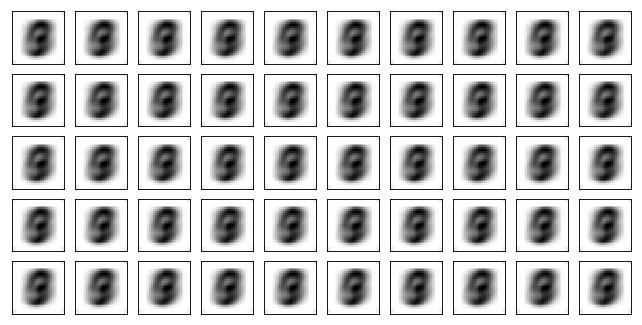

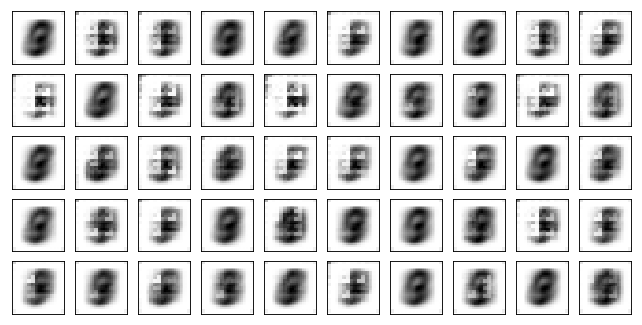

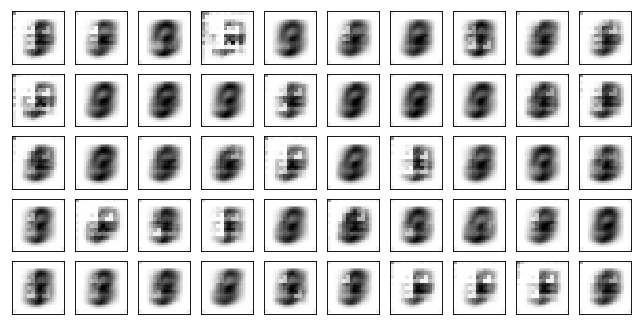

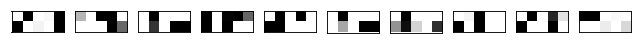

Model Adam Discr+bn+dp:


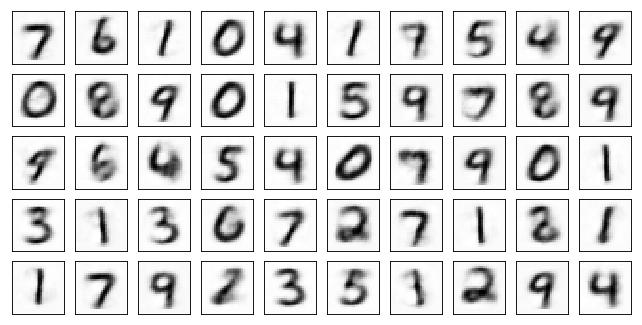

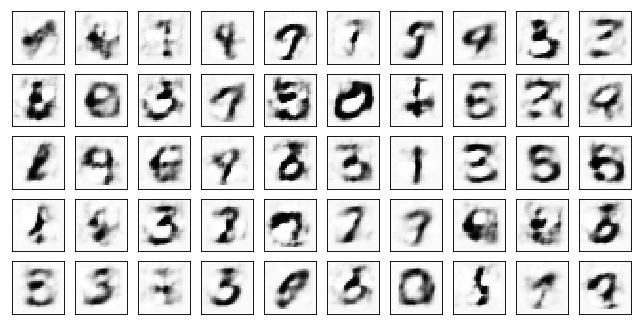

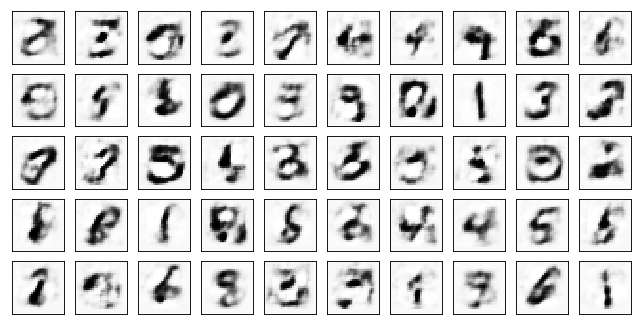

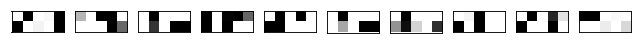

Test losses: 
Adam Discr+dp: 1.33418489 / 2.81206346 / 0.13416941 
Adam Discr+bn+dp: 0.80756414 / 2.77389359 / 0.12087225 

Train Epoch: 21 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7704 D:0.0085 Adam Discr+bn+dp: AE:0.7582 D:0.0100
Train Epoch: 21 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7769 D:0.0072 Adam Discr+bn+dp: AE:0.7689 D:0.0052
Train Epoch: 21 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7384 D:0.0206 Adam Discr+bn+dp: AE:0.7159 D:0.0435
Test losses: 
Adam Discr+dp: 1.34639406 / 1.98544180 / 0.16159704 
Adam Discr+bn+dp: 0.80090320 / 2.82500029 / 0.12030723 

Train Epoch: 22 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7650 D:0.0254 Adam Discr+bn+dp: AE:0.7221 D:0.0808
Train Epoch: 22 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7673 D:0.0042 Adam Discr+bn+dp: AE:0.6841 D:0.0116
Train Epoch: 22 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8078 D:0.0191 Adam Discr+bn+dp: AE:0.7077 D:0.1280
Test losses: 
Adam Discr+dp: 1.32877779 / 2.75725174 / 0.13713669 
Adam Disc

Train Epoch: 38 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8167 D:0.0659 Adam Discr+bn+dp: AE:0.7271 D:0.0104
Test losses: 
Adam Discr+dp: 1.34446073 / 2.92751122 / 0.09984251 
Adam Discr+bn+dp: 0.73715496 / 2.80491567 / 0.10099898 

Train Epoch: 39 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7962 D:0.0132 Adam Discr+bn+dp: AE:0.6763 D:0.0089
Train Epoch: 39 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8054 D:0.0084 Adam Discr+bn+dp: AE:0.7415 D:0.0088
Train Epoch: 39 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7697 D:0.0113 Adam Discr+bn+dp: AE:0.7306 D:0.0114
Test losses: 
Adam Discr+dp: 1.34571147 / 2.77524662 / 0.09613310 
Adam Discr+bn+dp: 0.73512471 / 2.77626157 / 0.10031062 

Train Epoch: 40 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8080 D:0.0068 Adam Discr+bn+dp: AE:0.6862 D:0.0075
Train Epoch: 40 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7920 D:0.0048 Adam Discr+bn+dp: AE:0.7157 D:0.0421
Train Epoch: 40 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8222 D:0.007

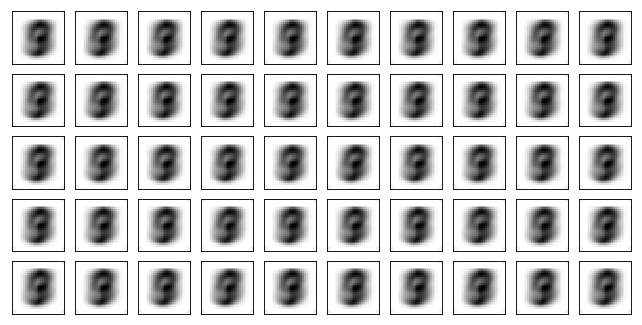

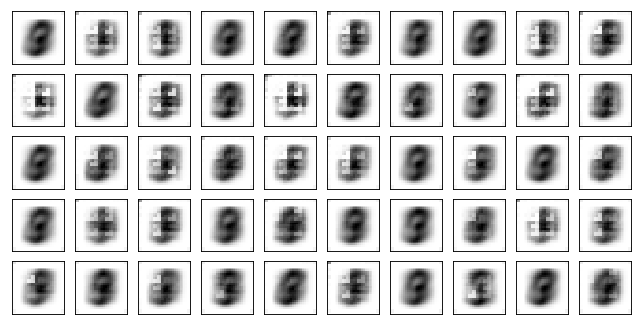

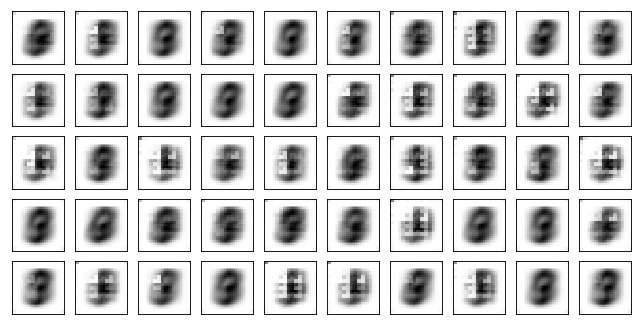

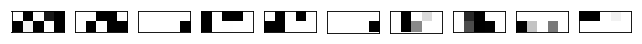

Model Adam Discr+bn+dp:


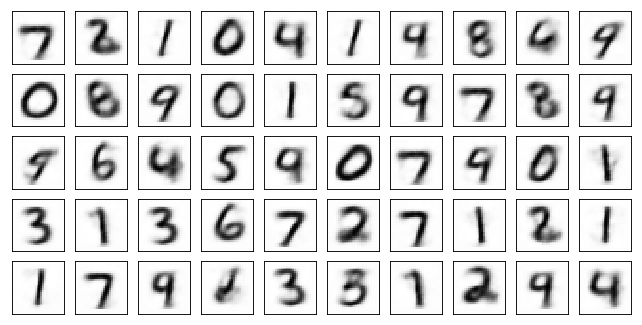

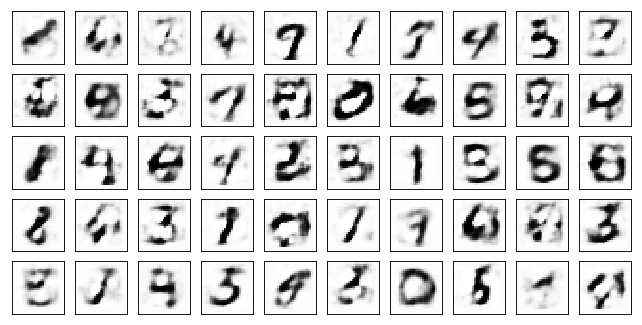

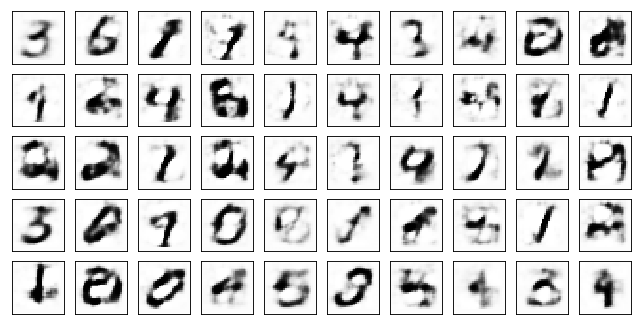

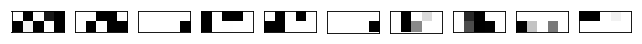

Test losses: 
Adam Discr+dp: 1.33578598 / 2.89535546 / 0.08863581 
Adam Discr+bn+dp: 0.73411274 / 2.79637384 / 0.10184480 

Train Epoch: 41 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8258 D:0.1186 Adam Discr+bn+dp: AE:0.6881 D:0.0046
Train Epoch: 41 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8108 D:0.0064 Adam Discr+bn+dp: AE:0.7186 D:0.0047
Train Epoch: 41 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.7585 D:0.0171 Adam Discr+bn+dp: AE:0.7195 D:0.0070
Test losses: 
Adam Discr+dp: 1.34257197 / 2.78149104 / 0.09266289 
Adam Discr+bn+dp: 0.73146367 / 2.87755179 / 0.09815000 

Train Epoch: 42 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7990 D:0.0062 Adam Discr+bn+dp: AE:0.7247 D:0.0130
Train Epoch: 42 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8054 D:0.0799 Adam Discr+bn+dp: AE:0.7146 D:0.0590
Train Epoch: 42 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8134 D:0.0072 Adam Discr+bn+dp: AE:0.6949 D:0.0132
Test losses: 
Adam Discr+dp: 1.33971643 / 3.01872492 / 0.08793281 
Adam Disc

Train Epoch: 58 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8602 D:0.0035 Adam Discr+bn+dp: AE:0.7031 D:0.0158
Test losses: 
Adam Discr+dp: 1.33713317 / 3.09404898 / 0.07660076 
Adam Discr+bn+dp: 0.72112370 / 2.89146018 / 0.06459970 

Train Epoch: 59 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8133 D:0.0567 Adam Discr+bn+dp: AE:0.6940 D:0.0069
Train Epoch: 59 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.7961 D:0.0043 Adam Discr+bn+dp: AE:0.7621 D:0.0565
Train Epoch: 59 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8514 D:0.1342 Adam Discr+bn+dp: AE:0.6889 D:0.0048
Test losses: 
Adam Discr+dp: 1.32164776 / 2.92190051 / 0.06914928 
Adam Discr+bn+dp: 0.71788812 / 2.90571547 / 0.07692462 

Train Epoch: 60 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.7783 D:0.0035 Adam Discr+bn+dp: AE:0.7115 D:0.0056
Train Epoch: 60 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8330 D:0.0861 Adam Discr+bn+dp: AE:0.7755 D:0.0399
Train Epoch: 60 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8372 D:0.003

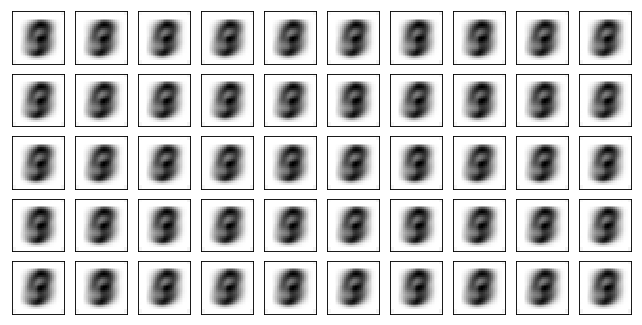

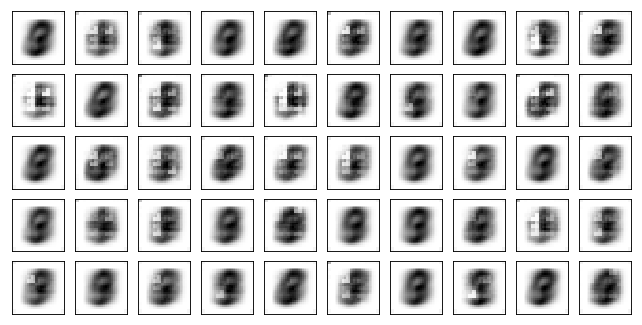

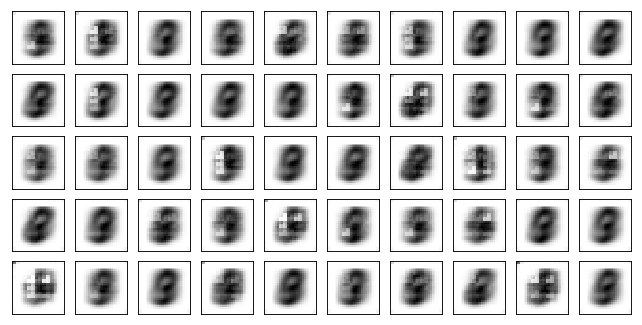

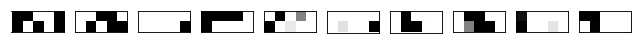

Model Adam Discr+bn+dp:


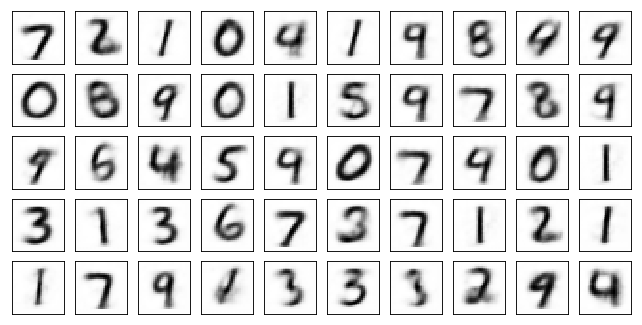

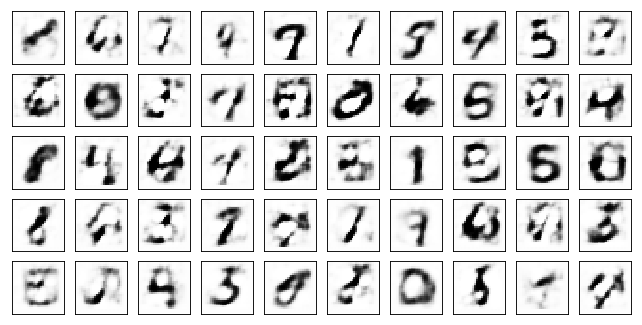

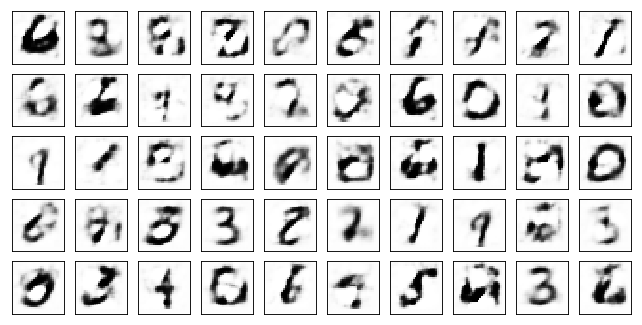

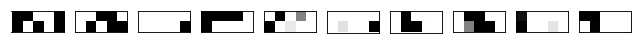

Test losses: 
Adam Discr+dp: 1.33429801 / 3.09115601 / 0.06167689 
Adam Discr+bn+dp: 0.71879506 / 2.96399140 / 0.06832671 

Train Epoch: 61 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8248 D:0.0661 Adam Discr+bn+dp: AE:0.7229 D:0.0071
Train Epoch: 61 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8143 D:0.0224 Adam Discr+bn+dp: AE:0.7399 D:0.0042
Train Epoch: 61 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8118 D:0.0618 Adam Discr+bn+dp: AE:0.7004 D:0.0050
Test losses: 
Adam Discr+dp: 1.33190036 / 3.06311393 / 0.06546114 
Adam Discr+bn+dp: 0.71797299 / 2.90307617 / 0.07023609 

Train Epoch: 62 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8457 D:0.0053 Adam Discr+bn+dp: AE:0.7251 D:0.0047
Train Epoch: 62 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8457 D:0.0331 Adam Discr+bn+dp: AE:0.7962 D:0.0056
Train Epoch: 62 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8118 D:0.0416 Adam Discr+bn+dp: AE:0.7473 D:0.0064
Test losses: 
Adam Discr+dp: 1.32729959 / 2.90767479 / 0.06760680 
Adam Disc

Train Epoch: 78 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8521 D:0.0028 Adam Discr+bn+dp: AE:0.7249 D:0.0034
Test losses: 
Adam Discr+dp: 1.31681418 / 3.13498425 / 0.04942540 
Adam Discr+bn+dp: 0.71799088 / 3.08946133 / 0.05724779 

Train Epoch: 79 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8311 D:0.0035 Adam Discr+bn+dp: AE:0.7389 D:0.0018
Train Epoch: 79 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8562 D:0.0056 Adam Discr+bn+dp: AE:0.7547 D:0.0021
Train Epoch: 79 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8405 D:0.0036 Adam Discr+bn+dp: AE:0.7602 D:0.0267
Test losses: 
Adam Discr+dp: 1.32840431 / 3.22741985 / 0.05026845 
Adam Discr+bn+dp: 0.71324337 / 3.11946559 / 0.05471487 

Train Epoch: 80 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8693 D:0.0038 Adam Discr+bn+dp: AE:0.7463 D:0.0037
Train Epoch: 80 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8329 D:0.0044 Adam Discr+bn+dp: AE:0.7520 D:0.0031
Train Epoch: 80 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8148 D:0.001

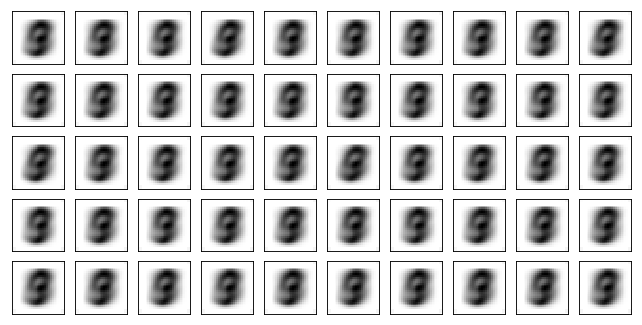

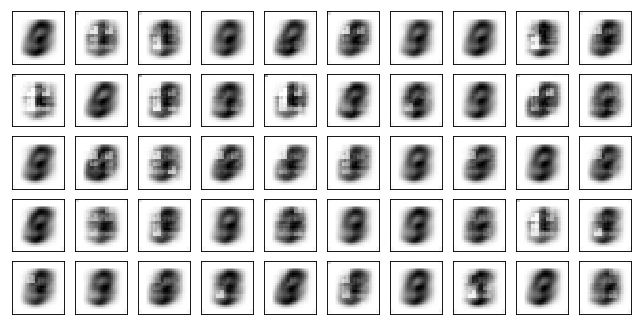

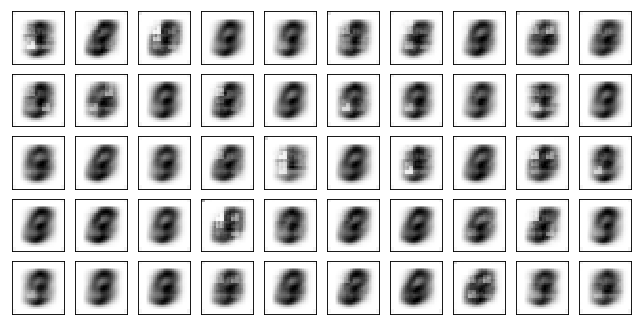

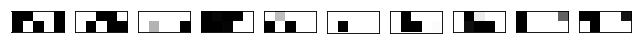

Model Adam Discr+bn+dp:


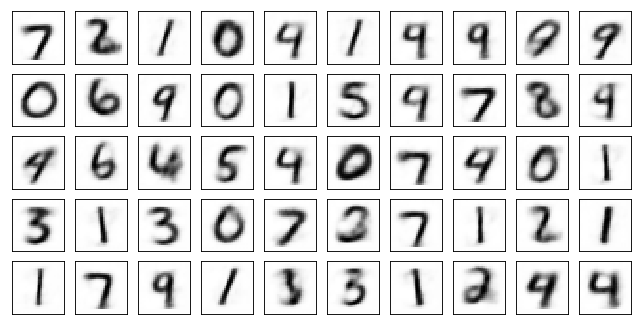

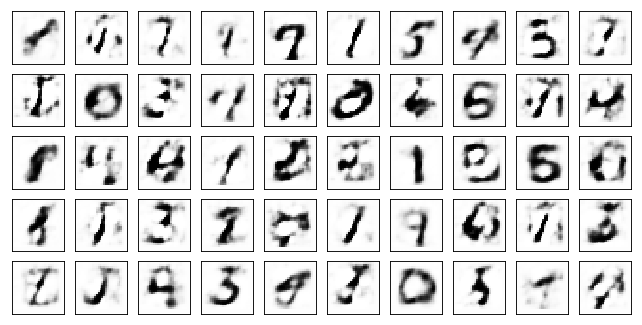

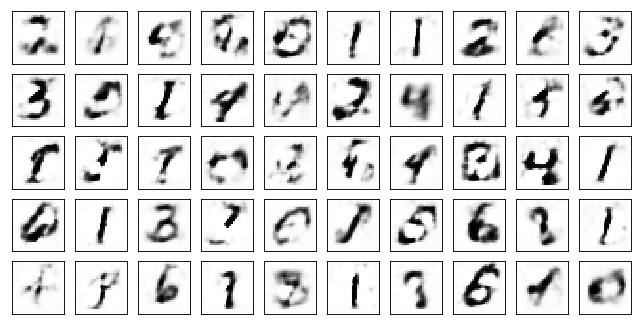

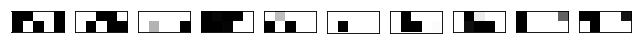

Test losses: 
Adam Discr+dp: 1.32341063 / 3.23030543 / 0.04683661 
Adam Discr+bn+dp: 0.71528476 / 3.19966817 / 0.05284852 

Train Epoch: 81 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8346 D:0.0030 Adam Discr+bn+dp: AE:0.7607 D:0.0033
Train Epoch: 81 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8102 D:0.0039 Adam Discr+bn+dp: AE:0.7148 D:0.0035
Train Epoch: 81 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8540 D:0.0078 Adam Discr+bn+dp: AE:0.7867 D:0.0111
Test losses: 
Adam Discr+dp: 1.32742441 / 3.30460835 / 0.04527647 
Adam Discr+bn+dp: 0.71121603 / 3.18213534 / 0.04520782 

Train Epoch: 82 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8661 D:0.0041 Adam Discr+bn+dp: AE:0.7578 D:0.0045
Train Epoch: 82 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8292 D:0.0112 Adam Discr+bn+dp: AE:0.7778 D:0.0255
Train Epoch: 82 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8548 D:0.0076 Adam Discr+bn+dp: AE:0.7769 D:0.0341
Test losses: 
Adam Discr+dp: 1.33798862 / 3.16950655 / 0.04826814 
Adam Disc

Train Epoch: 98 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8997 D:0.0023 Adam Discr+bn+dp: AE:0.7871 D:0.0025
Test losses: 
Adam Discr+dp: 1.32089305 / 3.55453396 / 0.04195405 
Adam Discr+bn+dp: 0.70443273 / 3.33602381 / 0.04214178 

Train Epoch: 99 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.8985 D:0.0016 Adam Discr+bn+dp: AE:0.7627 D:0.0360
Train Epoch: 99 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8937 D:0.0028 Adam Discr+bn+dp: AE:0.7617 D:0.0056
Train Epoch: 99 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9218 D:0.0017 Adam Discr+bn+dp: AE:0.8006 D:0.0015
Test losses: 
Adam Discr+dp: 1.33862531 / 3.63414693 / 0.03375952 
Adam Discr+bn+dp: 0.70455998 / 3.38963485 / 0.04147405 

Train Epoch: 100 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9186 D:0.0018 Adam Discr+bn+dp: AE:0.7806 D:0.0018
Train Epoch: 100 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8635 D:0.0021 Adam Discr+bn+dp: AE:0.7854 D:0.0014
Train Epoch: 100 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9261 D:0.

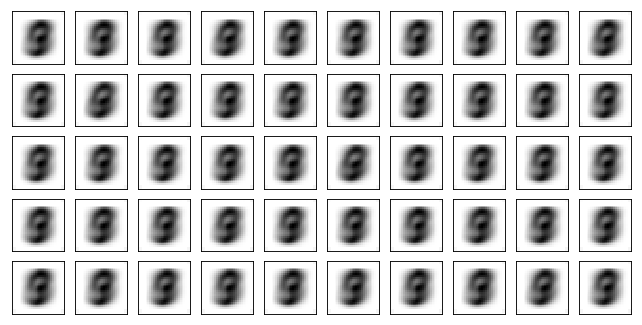

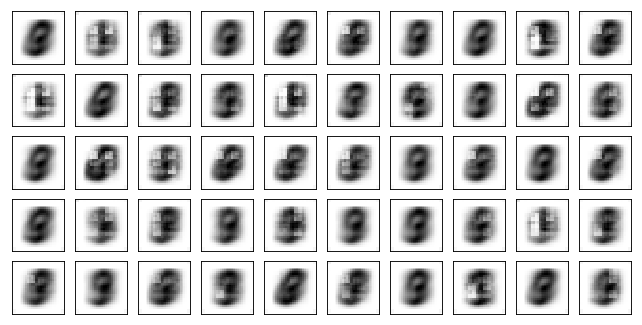

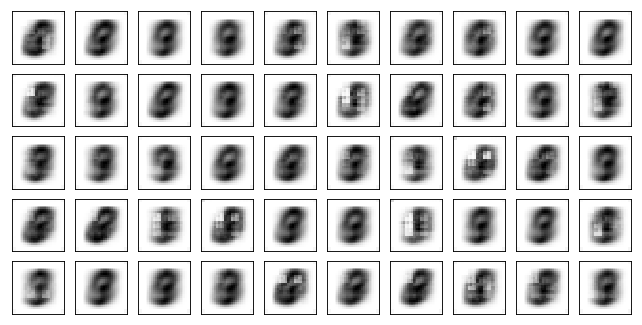

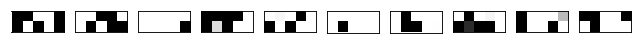

Model Adam Discr+bn+dp:


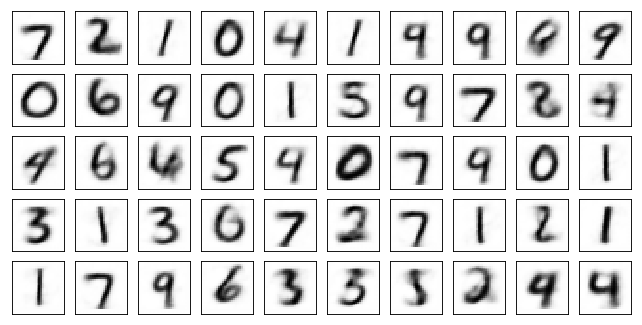

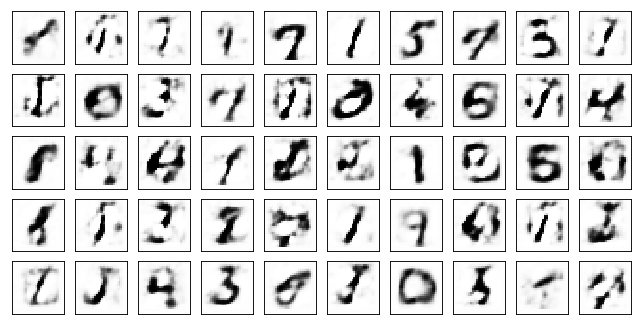

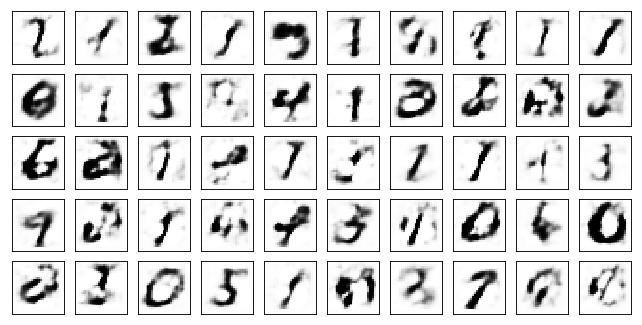

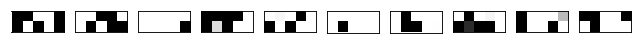

Test losses: 
Adam Discr+dp: 1.32627273 / 3.46833706 / 0.03737593 
Adam Discr+bn+dp: 0.70542336 / 3.30543041 / 0.04013686 

Train Epoch: 101 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9053 D:0.0012 Adam Discr+bn+dp: AE:0.7959 D:0.0021
Train Epoch: 101 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9114 D:0.0723 Adam Discr+bn+dp: AE:0.8157 D:0.0080
Train Epoch: 101 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8892 D:0.0016 Adam Discr+bn+dp: AE:0.7605 D:0.0052
Test losses: 
Adam Discr+dp: 1.32580590 / 3.36925411 / 0.03917461 
Adam Discr+bn+dp: 0.70819402 / 3.37883711 / 0.03887734 

Train Epoch: 102 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9009 D:0.0019 Adam Discr+bn+dp: AE:0.8107 D:0.0010
Train Epoch: 102 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8994 D:0.0022 Adam Discr+bn+dp: AE:0.7718 D:0.0031
Train Epoch: 102 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9160 D:0.0029 Adam Discr+bn+dp: AE:0.7789 D:0.0023
Test losses: 
Adam Discr+dp: 1.33275115 / 3.66233444 / 0.03356678 
Ada

Train Epoch: 118 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8725 D:0.0023 Adam Discr+bn+dp: AE:0.7946 D:0.0018
Test losses: 
Adam Discr+dp: 1.31185722 / 3.61274648 / 0.02713877 
Adam Discr+bn+dp: 0.70232886 / 3.43566418 / 0.02801079 

Train Epoch: 119 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9101 D:0.0043 Adam Discr+bn+dp: AE:0.7677 D:0.0025
Train Epoch: 119 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.8863 D:0.0025 Adam Discr+bn+dp: AE:0.8043 D:0.0223
Train Epoch: 119 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.8986 D:0.0019 Adam Discr+bn+dp: AE:0.8452 D:0.0022
Test losses: 
Adam Discr+dp: 1.31068444 / 3.63447690 / 0.03420016 
Adam Discr+bn+dp: 0.70054424 / 3.56364393 / 0.03087129 

Train Epoch: 120 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9218 D:0.0621 Adam Discr+bn+dp: AE:0.7824 D:0.0057
Train Epoch: 120 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9321 D:0.0013 Adam Discr+bn+dp: AE:0.8299 D:0.0010
Train Epoch: 120 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9097 

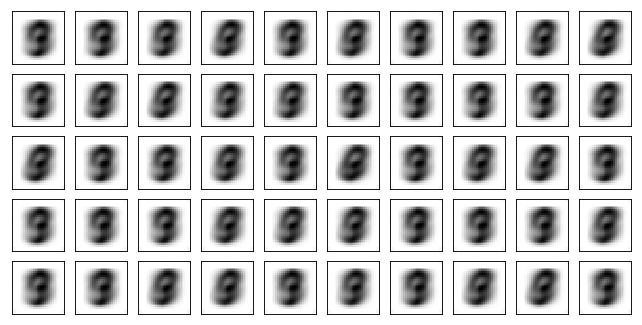

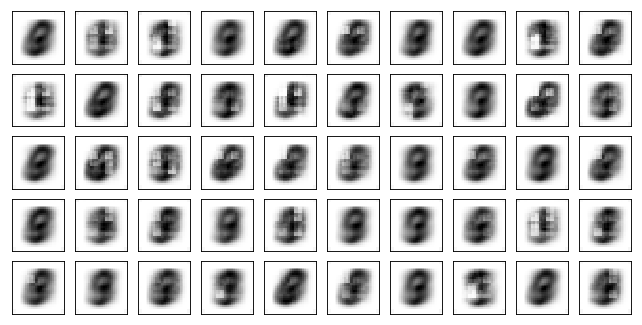

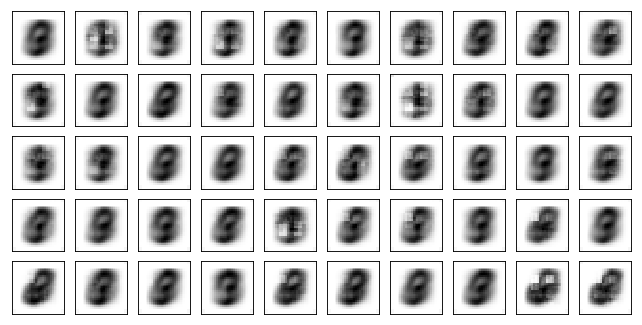

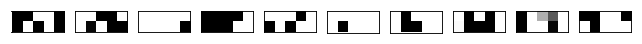

Model Adam Discr+bn+dp:


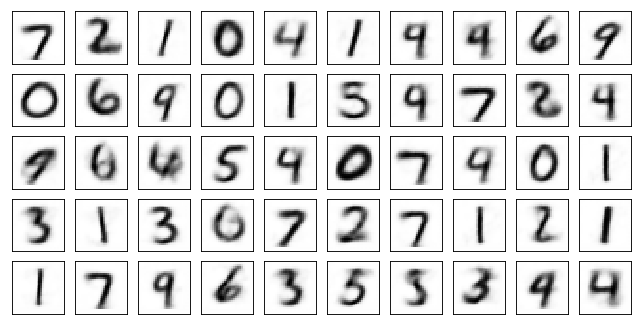

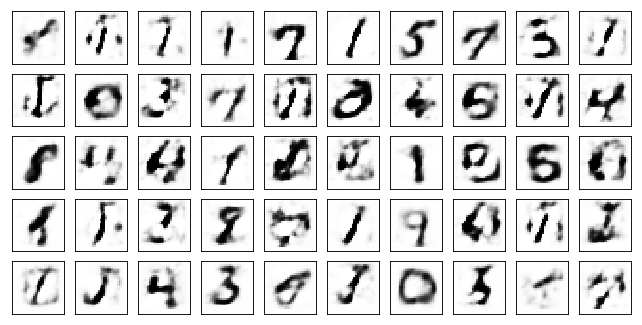

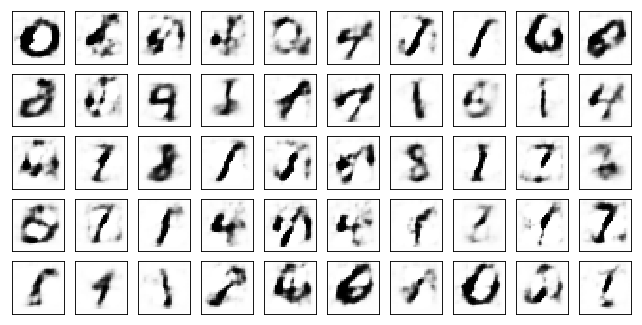

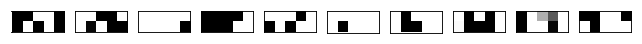

Test losses: 
Adam Discr+dp: 1.30167782 / 3.64428830 / 0.03467167 
Adam Discr+bn+dp: 0.69881588 / 3.45247102 / 0.03435623 

Train Epoch: 121 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9398 D:0.0013 Adam Discr+bn+dp: AE:0.7924 D:0.0033
Train Epoch: 121 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9094 D:0.0020 Adam Discr+bn+dp: AE:0.7903 D:0.0030
Train Epoch: 121 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9387 D:0.0234 Adam Discr+bn+dp: AE:0.8189 D:0.0328
Test losses: 
Adam Discr+dp: 1.31092119 / 3.60463381 / 0.03239830 
Adam Discr+bn+dp: 0.69690973 / 3.50024414 / 0.03001175 

Train Epoch: 122 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9191 D:0.0017 Adam Discr+bn+dp: AE:0.8211 D:0.0140
Train Epoch: 122 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9029 D:0.0015 Adam Discr+bn+dp: AE:0.8081 D:0.0021
Train Epoch: 122 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9067 D:0.0030 Adam Discr+bn+dp: AE:0.8160 D:0.0221
Test losses: 
Adam Discr+dp: 1.32599604 / 3.55997920 / 0.03322945 
Ada

Train Epoch: 138 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9043 D:0.0039 Adam Discr+bn+dp: AE:0.8395 D:0.0016
Test losses: 
Adam Discr+dp: 1.30375755 / 3.80331492 / 0.02789185 
Adam Discr+bn+dp: 0.69456953 / 3.73980331 / 0.02900849 

Train Epoch: 139 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9356 D:0.0014 Adam Discr+bn+dp: AE:0.8650 D:0.0007
Train Epoch: 139 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9709 D:0.0020 Adam Discr+bn+dp: AE:0.8555 D:0.0025
Train Epoch: 139 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9535 D:0.0013 Adam Discr+bn+dp: AE:0.7985 D:0.0011
Test losses: 
Adam Discr+dp: 1.30533612 / 3.70299125 / 0.02985129 
Adam Discr+bn+dp: 0.69321412 / 3.71713257 / 0.02549426 

Train Epoch: 140 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9545 D:0.0016 Adam Discr+bn+dp: AE:0.7739 D:0.0013
Train Epoch: 140 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9140 D:0.0063 Adam Discr+bn+dp: AE:0.8376 D:0.0014
Train Epoch: 140 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9267 

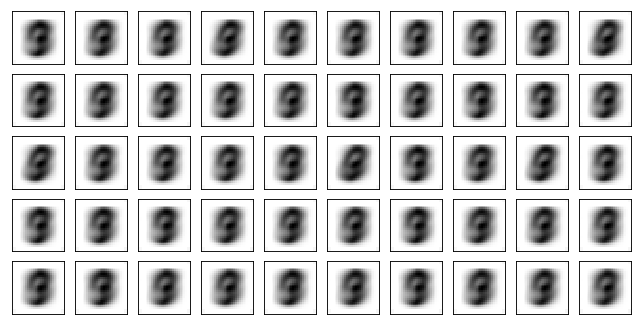

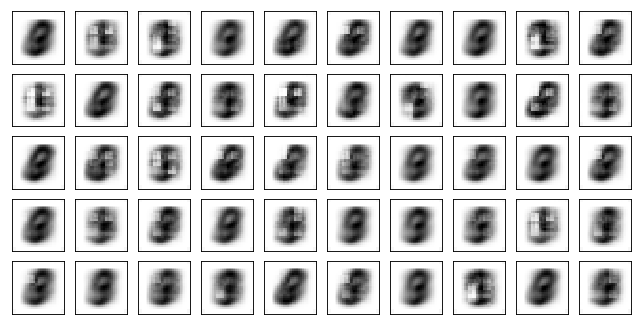

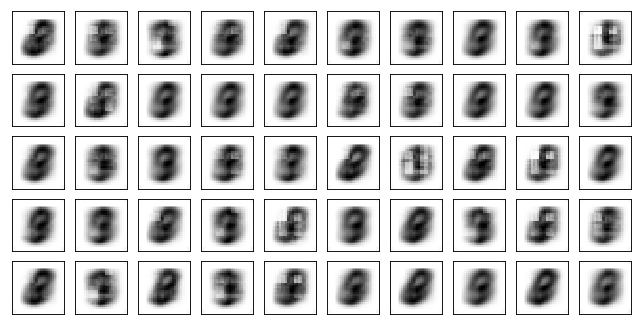

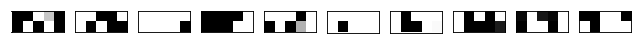

Model Adam Discr+bn+dp:


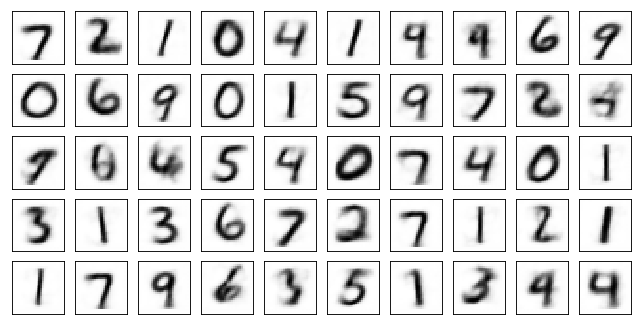

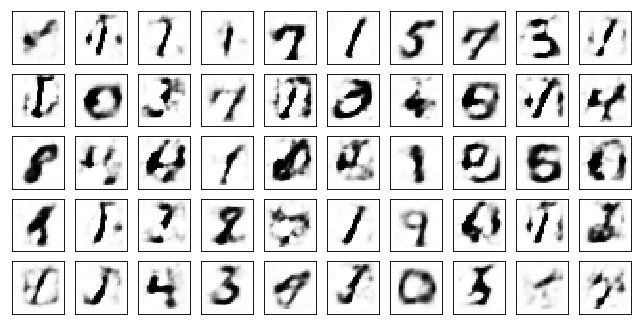

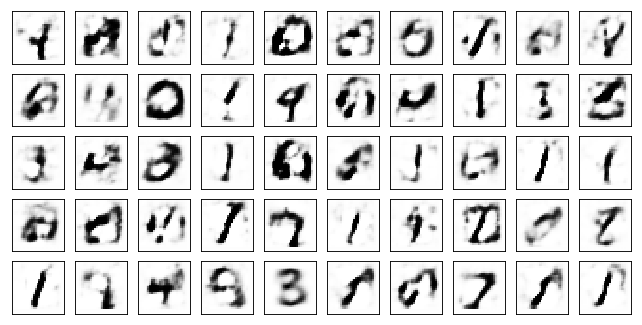

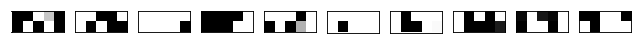

Test losses: 
Adam Discr+dp: 1.30613816 / 3.94951415 / 0.02324147 
Adam Discr+bn+dp: 0.69197923 / 3.53040767 / 0.02497564 

Train Epoch: 141 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9559 D:0.0013 Adam Discr+bn+dp: AE:0.7853 D:0.0031
Train Epoch: 141 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9536 D:0.0011 Adam Discr+bn+dp: AE:0.8247 D:0.0257
Train Epoch: 141 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9255 D:0.0018 Adam Discr+bn+dp: AE:0.8154 D:0.0017
Test losses: 
Adam Discr+dp: 1.30556428 / 3.81351280 / 0.02988085 
Adam Discr+bn+dp: 0.69233048 / 3.70037746 / 0.02840170 

Train Epoch: 142 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9287 D:0.0018 Adam Discr+bn+dp: AE:0.8507 D:0.0025
Train Epoch: 142 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9292 D:0.0015 Adam Discr+bn+dp: AE:0.8303 D:0.0010
Train Epoch: 142 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9308 D:0.0008 Adam Discr+bn+dp: AE:0.8135 D:0.0377
Test losses: 
Adam Discr+dp: 1.31036592 / 3.85657430 / 0.02673969 
Ada

Train Epoch: 158 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9405 D:0.0010 Adam Discr+bn+dp: AE:0.8160 D:0.0020
Test losses: 
Adam Discr+dp: 1.30640352 / 4.17697668 / 0.02531308 
Adam Discr+bn+dp: 0.68989384 / 3.86331296 / 0.02476695 

Train Epoch: 159 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9744 D:0.0029 Adam Discr+bn+dp: AE:0.8624 D:0.0710
Train Epoch: 159 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9397 D:0.0024 Adam Discr+bn+dp: AE:0.8522 D:0.0432
Train Epoch: 159 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9845 D:0.0011 Adam Discr+bn+dp: AE:0.9338 D:0.0008
Test losses: 
Adam Discr+dp: 1.30438423 / 4.25436258 / 0.02857491 
Adam Discr+bn+dp: 0.68866736 / 3.92039943 / 0.01828165 

Train Epoch: 160 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9615 D:0.0031 Adam Discr+bn+dp: AE:0.8552 D:0.0671
Train Epoch: 160 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9483 D:0.0011 Adam Discr+bn+dp: AE:0.8589 D:0.0056
Train Epoch: 160 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9500 

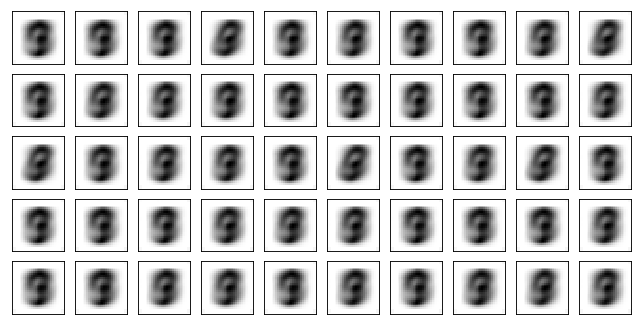

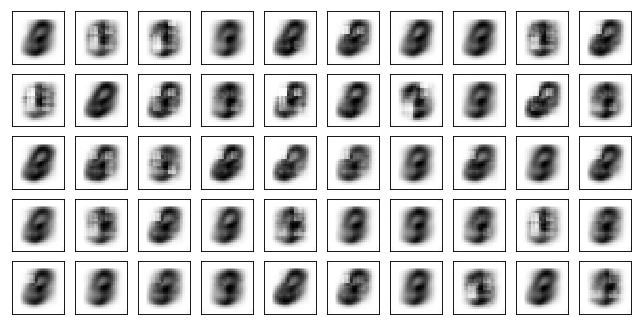

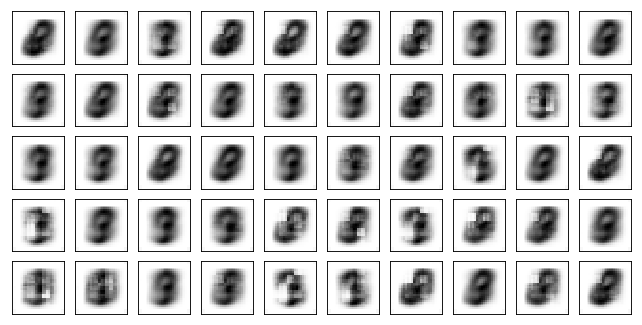

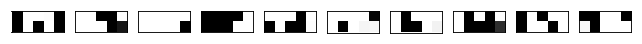

Model Adam Discr+bn+dp:


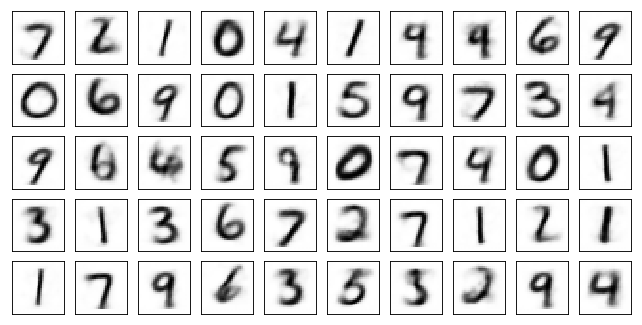

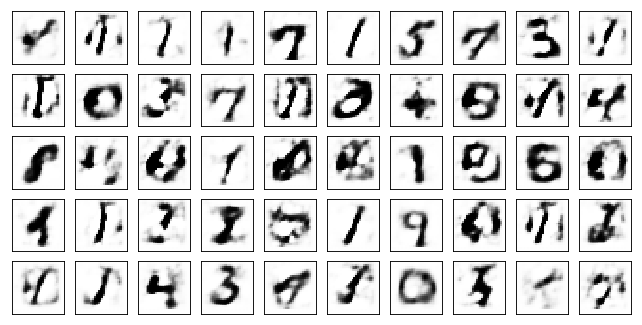

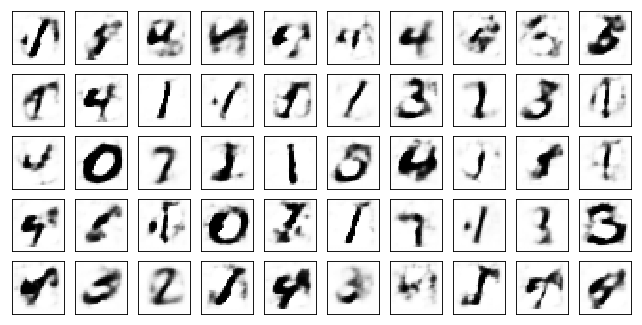

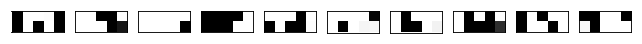

Test losses: 
Adam Discr+dp: 1.29697168 / 3.68413234 / 0.02280604 
Adam Discr+bn+dp: 0.69204915 / 3.88775802 / 0.02245645 

Train Epoch: 161 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9278 D:0.0018 Adam Discr+bn+dp: AE:0.8707 D:0.0015
Train Epoch: 161 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9699 D:0.0050 Adam Discr+bn+dp: AE:0.8604 D:0.0010
Train Epoch: 161 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9980 D:0.0678 Adam Discr+bn+dp: AE:0.9063 D:0.0012
Test losses: 
Adam Discr+dp: 1.29732513 / 3.95844102 / 0.02424968 
Adam Discr+bn+dp: 0.69252491 / 4.05277252 / 0.02241421 

Train Epoch: 162 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9683 D:0.0013 Adam Discr+bn+dp: AE:0.8875 D:0.0010
Train Epoch: 162 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9702 D:0.0501 Adam Discr+bn+dp: AE:0.8616 D:0.0393
Train Epoch: 162 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9610 D:0.0274 Adam Discr+bn+dp: AE:0.9134 D:0.0007
Test losses: 
Adam Discr+dp: 1.31491959 / 4.12131834 / 0.02218266 
Ada

Train Epoch: 178 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9686 D:0.0017 Adam Discr+bn+dp: AE:0.9038 D:0.0006
Test losses: 
Adam Discr+dp: 1.30583799 / 4.81645250 / 0.02233683 
Adam Discr+bn+dp: 0.68754697 / 4.12008572 / 0.01821959 

Train Epoch: 179 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9678 D:0.0012 Adam Discr+bn+dp: AE:0.9128 D:0.0006
Train Epoch: 179 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0161 D:0.0008 Adam Discr+bn+dp: AE:0.9140 D:0.0013
Train Epoch: 179 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9820 D:0.0010 Adam Discr+bn+dp: AE:0.8721 D:0.0006
Test losses: 
Adam Discr+dp: 1.29524946 / 4.34475470 / 0.02176720 
Adam Discr+bn+dp: 0.68784928 / 4.13126469 / 0.02099465 

Train Epoch: 180 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9862 D:0.0006 Adam Discr+bn+dp: AE:0.8897 D:0.0012
Train Epoch: 180 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0279 D:0.0007 Adam Discr+bn+dp: AE:0.8609 D:0.0337
Train Epoch: 180 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9764 

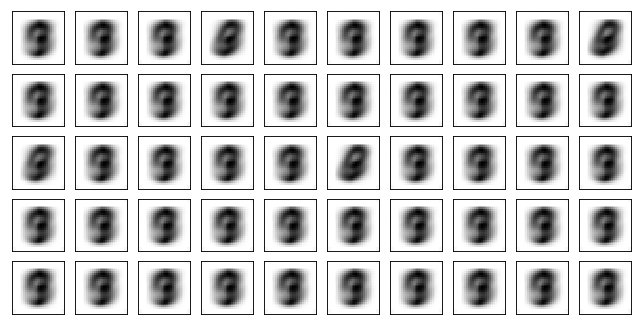

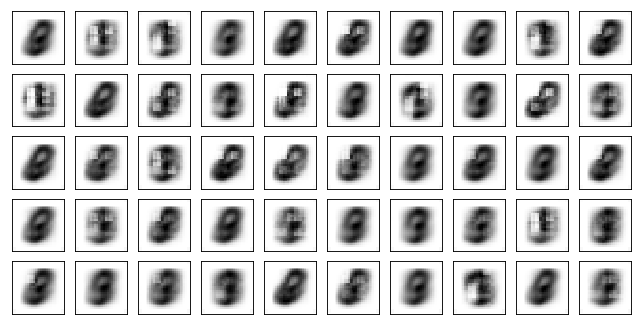

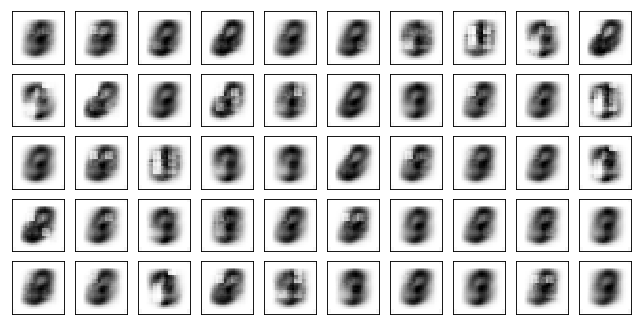

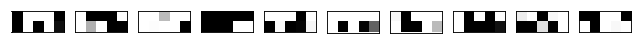

Model Adam Discr+bn+dp:


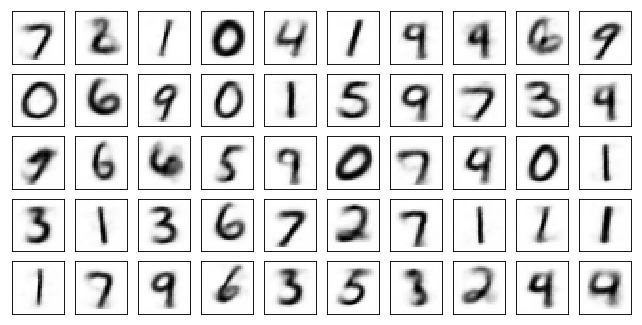

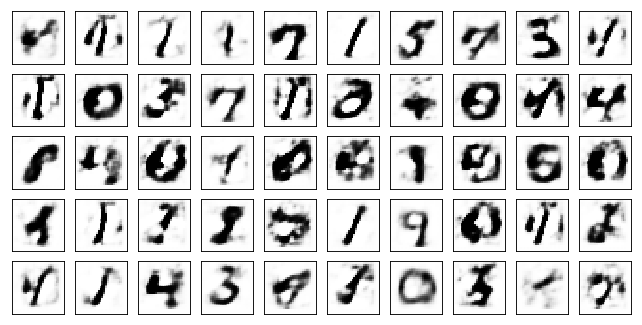

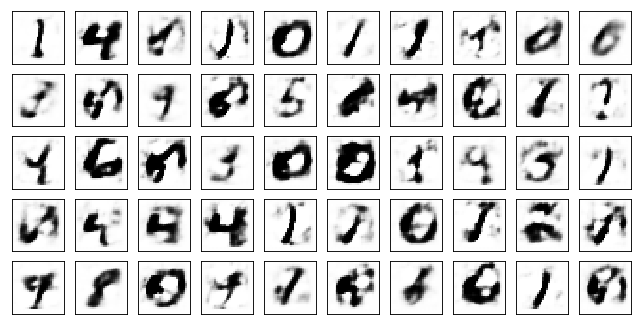

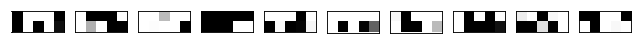

Test losses: 
Adam Discr+dp: 1.30214107 / 4.35159111 / 0.02335769 
Adam Discr+bn+dp: 0.68562931 / 3.96882987 / 0.02123399 

Train Epoch: 181 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9625 D:0.0022 Adam Discr+bn+dp: AE:0.8584 D:0.0008
Train Epoch: 181 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0224 D:0.0005 Adam Discr+bn+dp: AE:0.8836 D:0.0726
Train Epoch: 181 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9564 D:0.0014 Adam Discr+bn+dp: AE:0.8856 D:0.0007
Test losses: 
Adam Discr+dp: 1.29672432 / 3.99734020 / 0.02208943 
Adam Discr+bn+dp: 0.68420386 / 4.07942390 / 0.02381686 

Train Epoch: 182 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9766 D:0.0035 Adam Discr+bn+dp: AE:0.8911 D:0.0010
Train Epoch: 182 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9816 D:0.0006 Adam Discr+bn+dp: AE:0.9163 D:0.0008
Train Epoch: 182 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0002 D:0.0050 Adam Discr+bn+dp: AE:0.8742 D:0.0014
Test losses: 
Adam Discr+dp: 1.28753555 / 4.07732821 / 0.01987177 
Ada

Train Epoch: 198 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9626 D:0.0008 Adam Discr+bn+dp: AE:0.9472 D:0.0007
Test losses: 
Adam Discr+dp: 1.29391050 / 4.55149841 / 0.01911784 
Adam Discr+bn+dp: 0.69934714 / 4.09787369 / 0.02179291 

Train Epoch: 199 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0117 D:0.0010 Adam Discr+bn+dp: AE:0.9027 D:0.0009
Train Epoch: 199 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9949 D:0.0016 Adam Discr+bn+dp: AE:0.9344 D:0.0008
Train Epoch: 199 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0102 D:0.0007 Adam Discr+bn+dp: AE:0.8955 D:0.0007
Test losses: 
Adam Discr+dp: 1.28106368 / 4.46992159 / 0.01806430 
Adam Discr+bn+dp: 0.70445591 / 4.15676308 / 0.02162455 

Train Epoch: 200 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9590 D:0.0005 Adam Discr+bn+dp: AE:0.9528 D:0.0011
Train Epoch: 200 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0378 D:0.0012 Adam Discr+bn+dp: AE:0.8889 D:0.0010
Train Epoch: 200 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0886 

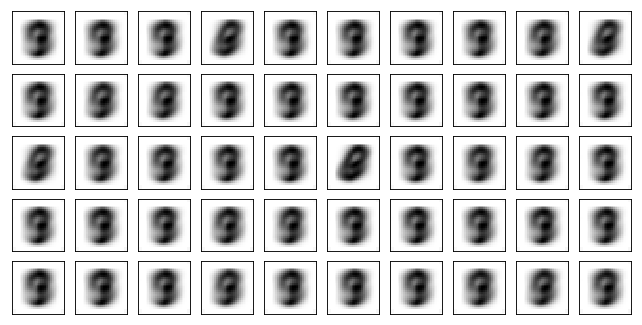

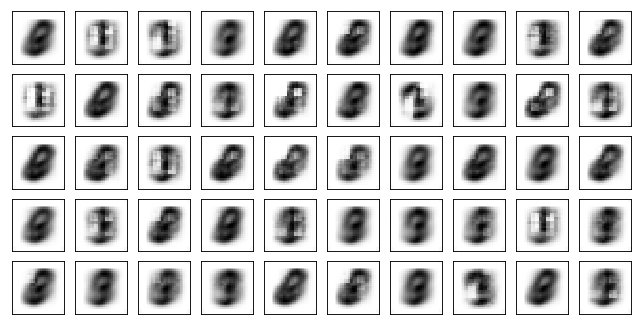

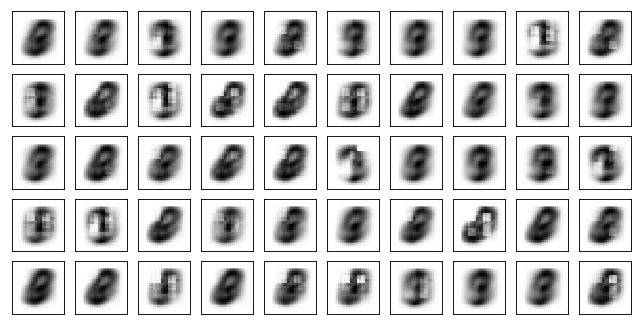

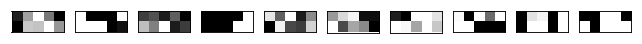

Model Adam Discr+bn+dp:


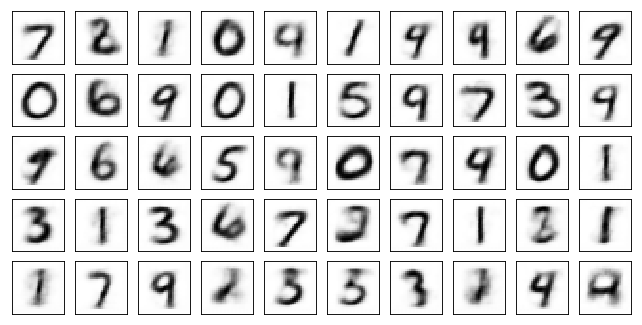

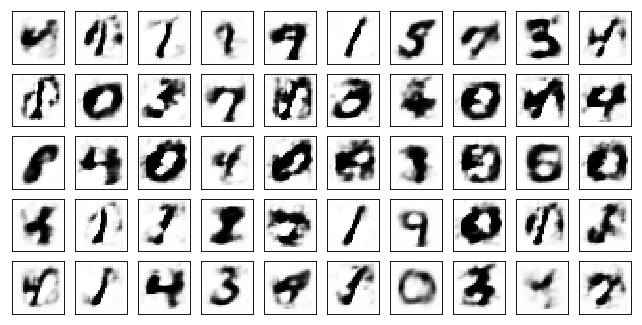

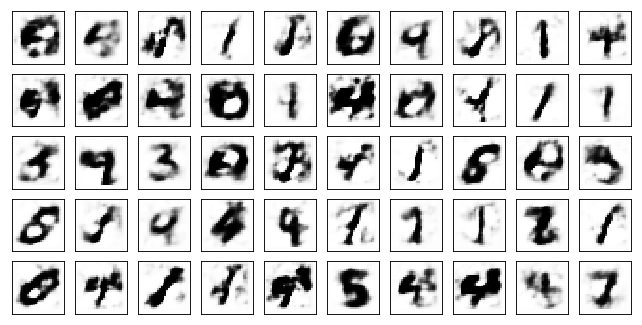

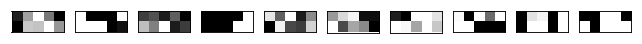

Test losses: 
Adam Discr+dp: 1.28670800 / 4.74446964 / 0.02063952 
Adam Discr+bn+dp: 0.71456236 / 4.11385441 / 0.01790026 

Train Epoch: 201 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0654 D:0.0004 Adam Discr+bn+dp: AE:0.9135 D:0.0007
Train Epoch: 201 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0237 D:0.0478 Adam Discr+bn+dp: AE:0.8877 D:0.0013
Train Epoch: 201 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0287 D:0.0010 Adam Discr+bn+dp: AE:0.9830 D:0.0005
Test losses: 
Adam Discr+dp: 1.29862666 / 4.06586552 / 0.01726508 
Adam Discr+bn+dp: 0.70445800 / 4.30570793 / 0.02550030 

Train Epoch: 202 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0508 D:0.0012 Adam Discr+bn+dp: AE:0.9844 D:0.0005
Train Epoch: 202 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9926 D:0.0018 Adam Discr+bn+dp: AE:0.9482 D:0.0008
Train Epoch: 202 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0396 D:0.0399 Adam Discr+bn+dp: AE:0.9145 D:0.0005
Test losses: 
Adam Discr+dp: 1.28680360 / 4.92158556 / 0.01746407 
Ada

Train Epoch: 218 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:0.9492 D:0.0013 Adam Discr+bn+dp: AE:0.8668 D:0.0006
Test losses: 
Adam Discr+dp: 1.28631473 / 4.19364929 / 0.01625835 
Adam Discr+bn+dp: 0.68153840 / 3.96196103 / 0.01498815 

Train Epoch: 219 [0/50000 (0%)]	Losses Adam Discr+dp: AE:0.9431 D:0.0008 Adam Discr+bn+dp: AE:0.8946 D:0.0008
Train Epoch: 219 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:0.9996 D:0.0009 Adam Discr+bn+dp: AE:0.8680 D:0.0006
Train Epoch: 219 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0576 D:0.0005 Adam Discr+bn+dp: AE:0.9447 D:0.0006
Test losses: 
Adam Discr+dp: 1.28980923 / 4.60225201 / 0.01545015 
Adam Discr+bn+dp: 0.67400885 / 4.22112274 / 0.01968240 

Train Epoch: 220 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0473 D:0.0005 Adam Discr+bn+dp: AE:0.9234 D:0.0009
Train Epoch: 220 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0755 D:0.0012 Adam Discr+bn+dp: AE:0.9060 D:0.0010
Train Epoch: 220 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0531 

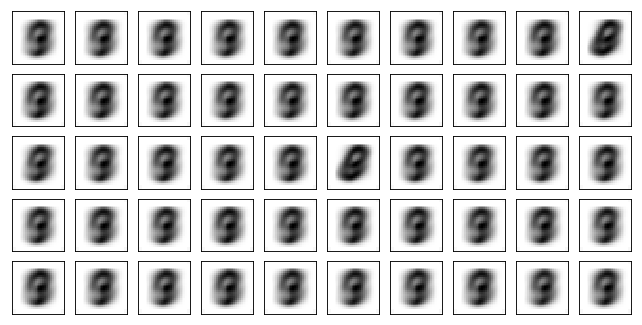

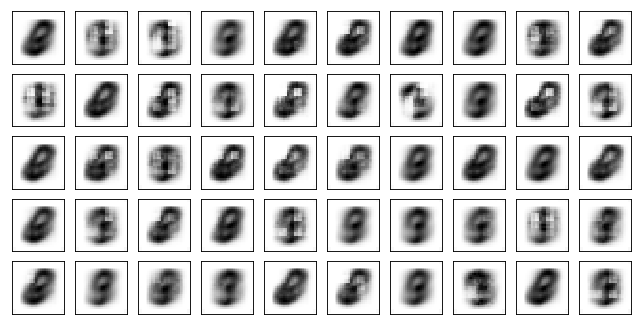

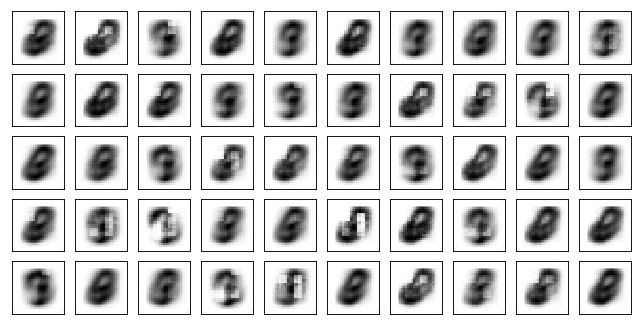

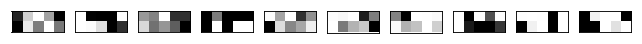

Model Adam Discr+bn+dp:


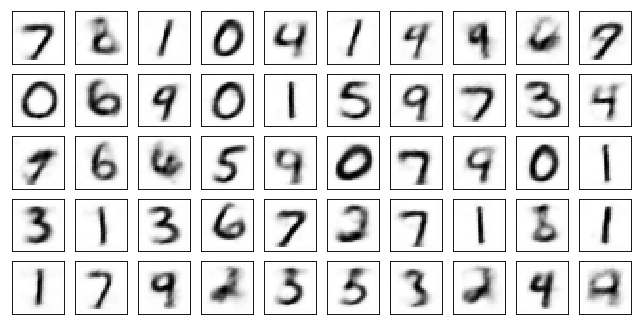

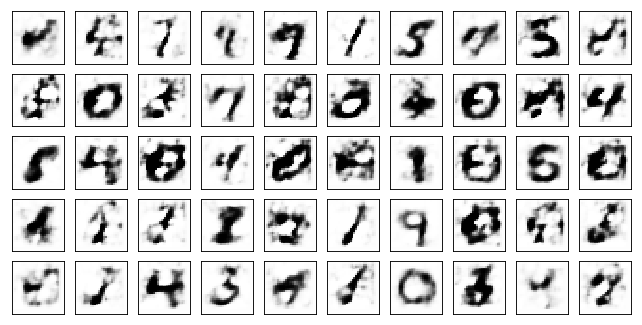

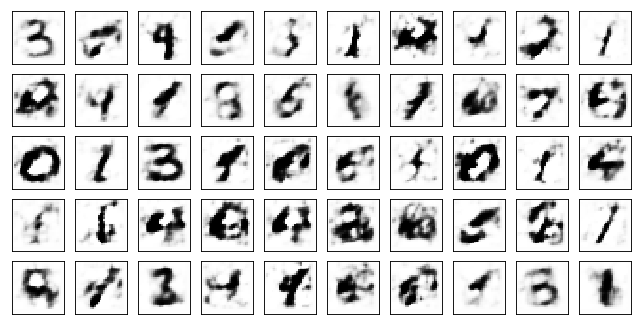

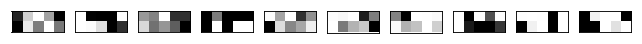

Test losses: 
Adam Discr+dp: 1.29553628 / 4.95189142 / 0.01966150 
Adam Discr+bn+dp: 0.67733169 / 4.09428215 / 0.01765909 

Train Epoch: 221 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1198 D:0.0004 Adam Discr+bn+dp: AE:0.8919 D:0.0006
Train Epoch: 221 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0557 D:0.0008 Adam Discr+bn+dp: AE:0.8984 D:0.0005
Train Epoch: 221 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0699 D:0.0002 Adam Discr+bn+dp: AE:0.9001 D:0.0007
Test losses: 
Adam Discr+dp: 1.28897929 / 4.94157267 / 0.02014717 
Adam Discr+bn+dp: 0.67643338 / 4.09708023 / 0.01588722 

Train Epoch: 222 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1053 D:0.0005 Adam Discr+bn+dp: AE:0.9246 D:0.0008
Train Epoch: 222 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0468 D:0.0006 Adam Discr+bn+dp: AE:0.9471 D:0.0009
Train Epoch: 222 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0602 D:0.0003 Adam Discr+bn+dp: AE:0.8590 D:0.0032
Test losses: 
Adam Discr+dp: 1.29192531 / 4.64215183 / 0.01776694 
Ada

Train Epoch: 238 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0477 D:0.0003 Adam Discr+bn+dp: AE:0.9062 D:0.0008
Test losses: 
Adam Discr+dp: 1.29564774 / 5.08452129 / 0.01387718 
Adam Discr+bn+dp: 0.67928976 / 4.17020416 / 0.01958811 

Train Epoch: 239 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0659 D:0.0006 Adam Discr+bn+dp: AE:0.9573 D:0.0005
Train Epoch: 239 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0972 D:0.0005 Adam Discr+bn+dp: AE:0.8599 D:0.0007
Train Epoch: 239 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0709 D:0.0012 Adam Discr+bn+dp: AE:0.8858 D:0.0011
Test losses: 
Adam Discr+dp: 1.29671371 / 5.23465300 / 0.01591065 
Adam Discr+bn+dp: 0.67908257 / 4.00302553 / 0.01623671 

Train Epoch: 240 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0892 D:0.0018 Adam Discr+bn+dp: AE:0.8639 D:0.0007
Train Epoch: 240 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0691 D:0.0009 Adam Discr+bn+dp: AE:0.8933 D:0.0013
Train Epoch: 240 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0738 

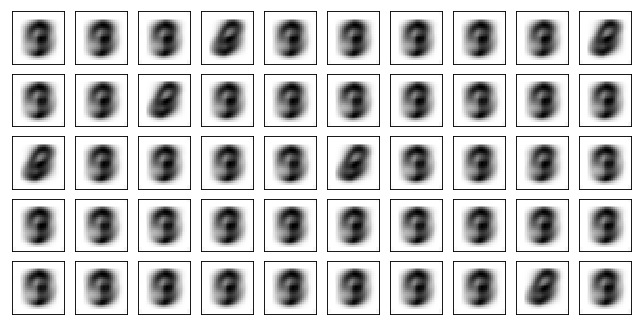

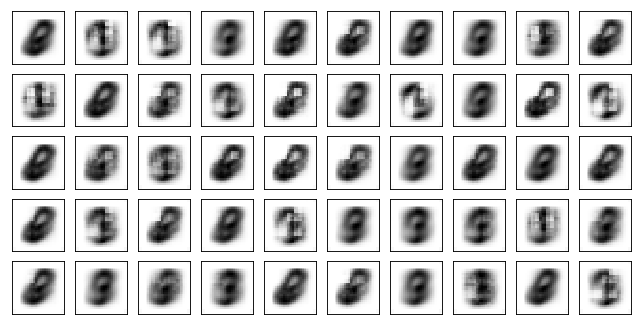

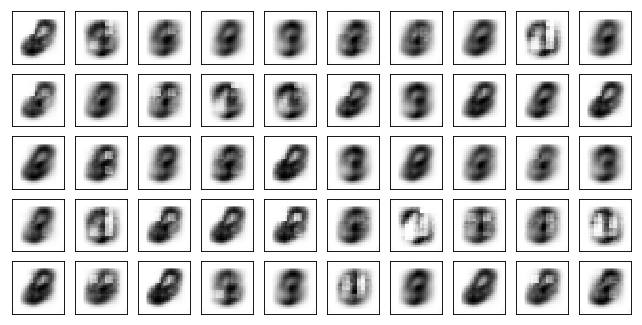

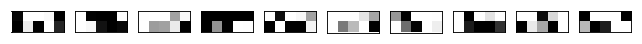

Model Adam Discr+bn+dp:


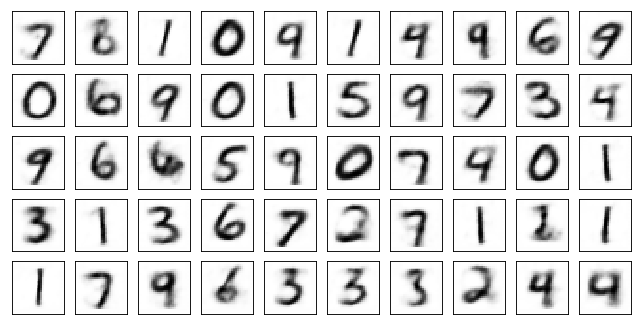

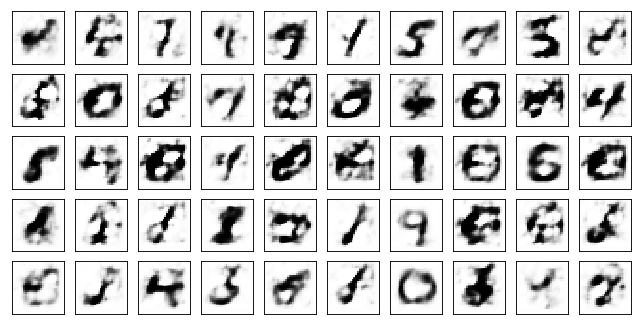

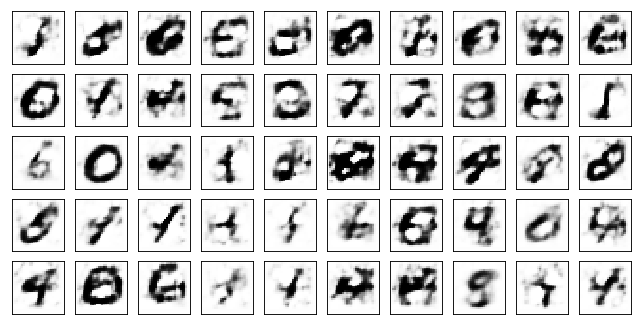

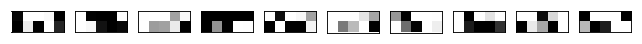

Test losses: 
Adam Discr+dp: 1.28751314 / 4.86055326 / 0.01416942 
Adam Discr+bn+dp: 0.68520719 / 4.20799446 / 0.01893573 

Train Epoch: 241 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0810 D:0.0007 Adam Discr+bn+dp: AE:0.8937 D:0.0009
Train Epoch: 241 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0782 D:0.0955 Adam Discr+bn+dp: AE:0.9063 D:0.0013
Train Epoch: 241 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1092 D:0.0006 Adam Discr+bn+dp: AE:0.9102 D:0.0003
Test losses: 
Adam Discr+dp: 1.28338706 / 4.75184679 / 0.01817260 
Adam Discr+bn+dp: 0.68552530 / 4.20103359 / 0.01456279 

Train Epoch: 242 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0420 D:0.0015 Adam Discr+bn+dp: AE:0.9205 D:0.0012
Train Epoch: 242 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0669 D:0.0009 Adam Discr+bn+dp: AE:0.9189 D:0.0003
Train Epoch: 242 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0660 D:0.0006 Adam Discr+bn+dp: AE:0.9295 D:0.0004
Test losses: 
Adam Discr+dp: 1.29959154 / 4.86571121 / 0.01481509 
Ada

Train Epoch: 258 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0852 D:0.0008 Adam Discr+bn+dp: AE:0.8872 D:0.0010
Test losses: 
Adam Discr+dp: 1.29769492 / 5.12313652 / 0.01457456 
Adam Discr+bn+dp: 0.67656165 / 4.16150856 / 0.01456529 

Train Epoch: 259 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0974 D:0.0007 Adam Discr+bn+dp: AE:0.9010 D:0.0175
Train Epoch: 259 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1085 D:0.0023 Adam Discr+bn+dp: AE:0.9031 D:0.0415
Train Epoch: 259 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0799 D:0.0007 Adam Discr+bn+dp: AE:0.8960 D:0.0013
Test losses: 
Adam Discr+dp: 1.27362633 / 5.08313179 / 0.01409083 
Adam Discr+bn+dp: 0.68414283 / 4.23368025 / 0.01982964 

Train Epoch: 260 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0179 D:0.0004 Adam Discr+bn+dp: AE:0.9162 D:0.0005
Train Epoch: 260 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1893 D:0.0002 Adam Discr+bn+dp: AE:0.8991 D:0.0005
Train Epoch: 260 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1466 

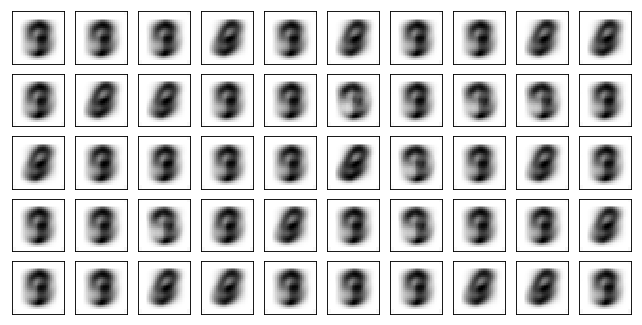

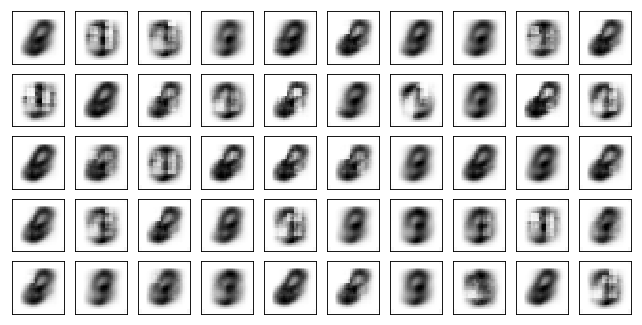

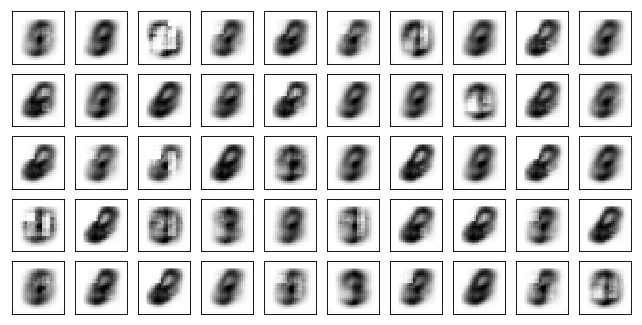

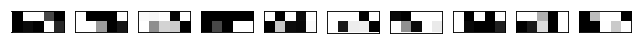

Model Adam Discr+bn+dp:


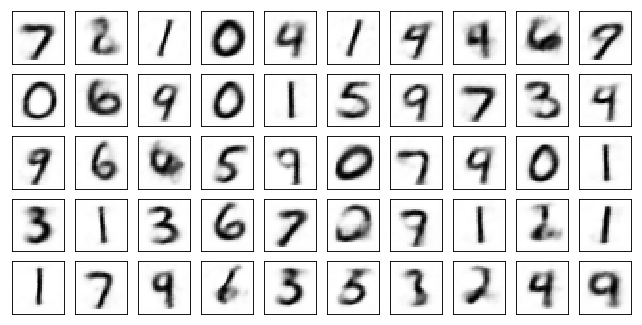

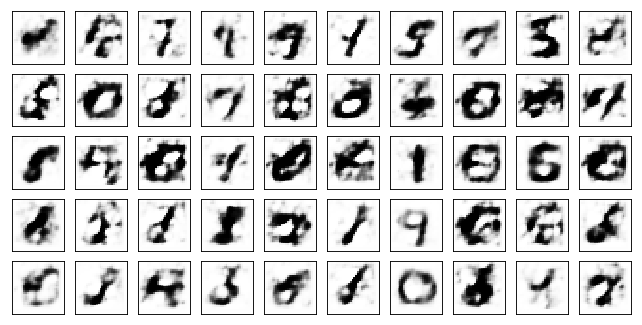

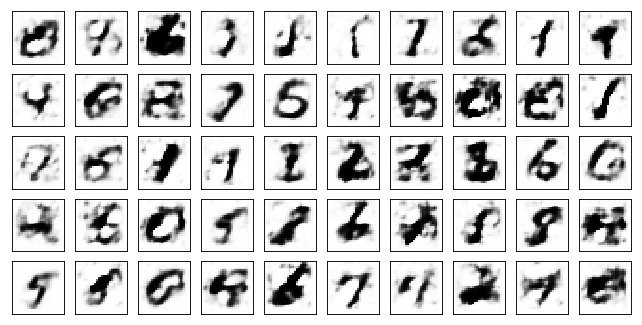

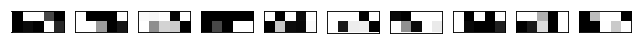

Test losses: 
Adam Discr+dp: 1.28007579 / 5.23548222 / 0.01170947 
Adam Discr+bn+dp: 0.67117333 / 4.13025427 / 0.01581424 

Train Epoch: 261 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0825 D:0.0142 Adam Discr+bn+dp: AE:0.9265 D:0.0021
Train Epoch: 261 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0476 D:0.0007 Adam Discr+bn+dp: AE:0.8960 D:0.0012
Train Epoch: 261 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1584 D:0.0008 Adam Discr+bn+dp: AE:0.8905 D:0.0007
Test losses: 
Adam Discr+dp: 1.26783693 / 4.77104855 / 0.01485771 
Adam Discr+bn+dp: 0.67418659 / 4.15210962 / 0.01659121 

Train Epoch: 262 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1188 D:0.0005 Adam Discr+bn+dp: AE:0.9200 D:0.0384
Train Epoch: 262 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0840 D:0.0004 Adam Discr+bn+dp: AE:0.8873 D:0.0011
Train Epoch: 262 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1017 D:0.0004 Adam Discr+bn+dp: AE:0.8984 D:0.0007
Test losses: 
Adam Discr+dp: 1.30404735 / 5.18967772 / 0.00990306 
Ada

Train Epoch: 278 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0766 D:0.0010 Adam Discr+bn+dp: AE:0.9934 D:0.0004
Test losses: 
Adam Discr+dp: 1.28051603 / 4.81854630 / 0.01237260 
Adam Discr+bn+dp: 0.66692758 / 4.31422615 / 0.01736848 

Train Epoch: 279 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0321 D:0.0024 Adam Discr+bn+dp: AE:0.9700 D:0.0006
Train Epoch: 279 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1531 D:0.0009 Adam Discr+bn+dp: AE:0.9222 D:0.0003
Train Epoch: 279 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0947 D:0.0004 Adam Discr+bn+dp: AE:0.9448 D:0.0005
Test losses: 
Adam Discr+dp: 1.28946900 / 5.13174725 / 0.01047135 
Adam Discr+bn+dp: 0.67080820 / 4.45081758 / 0.01716416 

Train Epoch: 280 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0951 D:0.0316 Adam Discr+bn+dp: AE:0.9643 D:0.0006
Train Epoch: 280 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0870 D:0.0003 Adam Discr+bn+dp: AE:0.9093 D:0.0822
Train Epoch: 280 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1432 

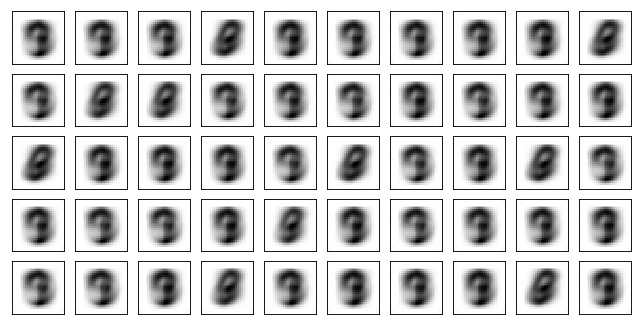

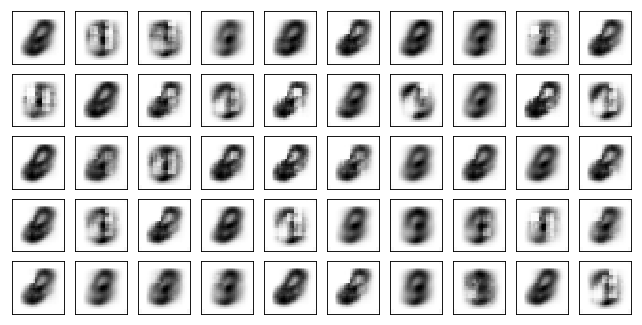

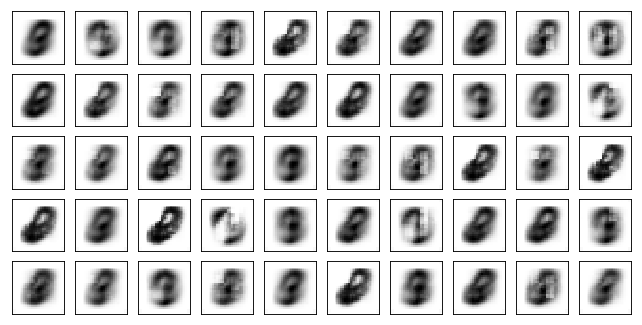

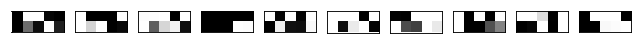

Model Adam Discr+bn+dp:


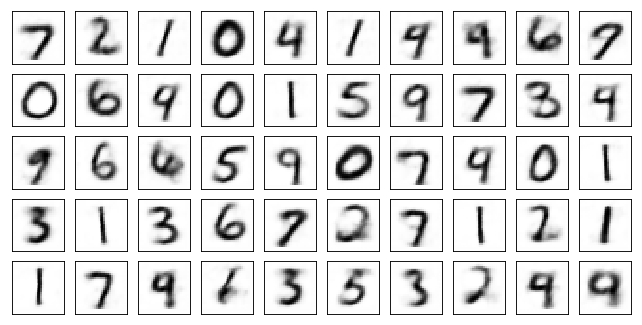

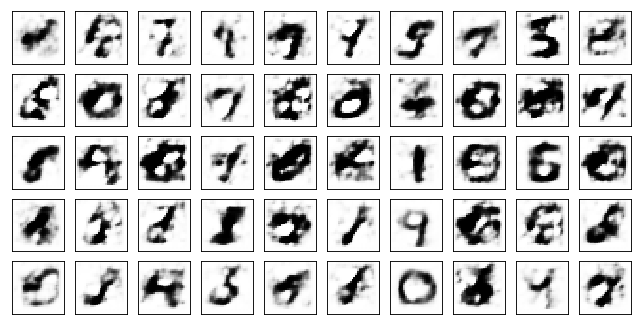

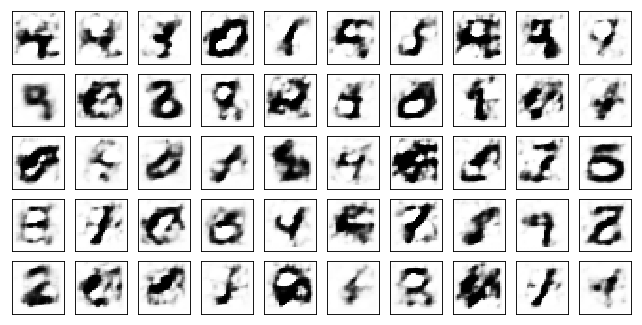

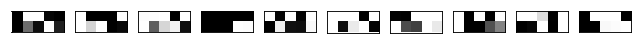

Test losses: 
Adam Discr+dp: 1.28159988 / 5.29616022 / 0.01267528 
Adam Discr+bn+dp: 0.67077690 / 4.15514660 / 0.01314176 

Train Epoch: 281 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1346 D:0.0003 Adam Discr+bn+dp: AE:0.9072 D:0.0013
Train Epoch: 281 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1544 D:0.0009 Adam Discr+bn+dp: AE:0.9255 D:0.0100
Train Epoch: 281 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0578 D:0.0005 Adam Discr+bn+dp: AE:0.8932 D:0.0006
Test losses: 
Adam Discr+dp: 1.28399444 / 5.12431574 / 0.01183046 
Adam Discr+bn+dp: 0.66775793 / 4.17097902 / 0.01326280 

Train Epoch: 282 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.0509 D:0.0004 Adam Discr+bn+dp: AE:0.8917 D:0.0016
Train Epoch: 282 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1763 D:0.0012 Adam Discr+bn+dp: AE:0.8913 D:0.0005
Train Epoch: 282 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1114 D:0.0012 Adam Discr+bn+dp: AE:0.9089 D:0.0015
Test losses: 
Adam Discr+dp: 1.29107952 / 5.40181160 / 0.00849868 
Ada

Train Epoch: 298 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.0657 D:0.0010 Adam Discr+bn+dp: AE:0.9183 D:0.0006
Test losses: 
Adam Discr+dp: 1.27776158 / 5.01766634 / 0.00920336 
Adam Discr+bn+dp: 0.66831195 / 4.37939692 / 0.01360146 

Train Epoch: 299 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1388 D:0.0009 Adam Discr+bn+dp: AE:0.8621 D:0.0004
Train Epoch: 299 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.0810 D:0.0011 Adam Discr+bn+dp: AE:0.9659 D:0.0009
Train Epoch: 299 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1581 D:0.0004 Adam Discr+bn+dp: AE:0.9313 D:0.0009
Test losses: 
Adam Discr+dp: 1.28174603 / 5.16103983 / 0.00804983 
Adam Discr+bn+dp: 0.66578060 / 4.40201187 / 0.01092060 

Train Epoch: 300 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1853 D:0.0010 Adam Discr+bn+dp: AE:0.9391 D:0.0005
Train Epoch: 300 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1241 D:0.0052 Adam Discr+bn+dp: AE:0.9190 D:0.0007
Train Epoch: 300 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1290 

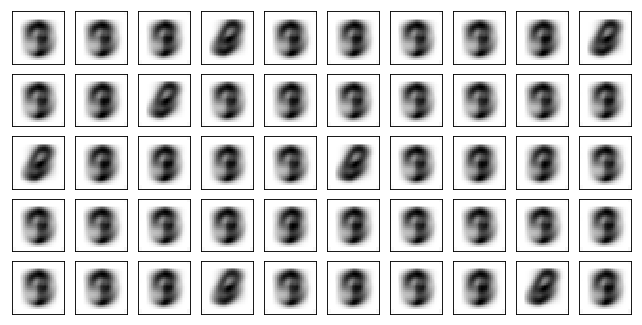

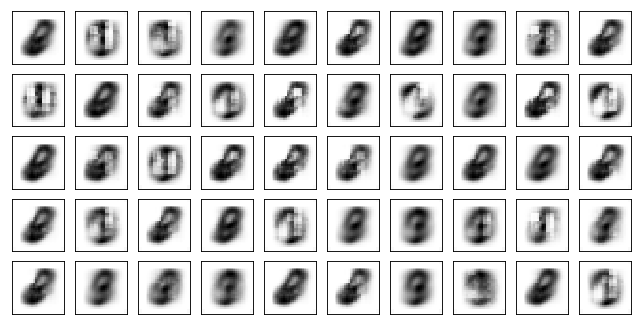

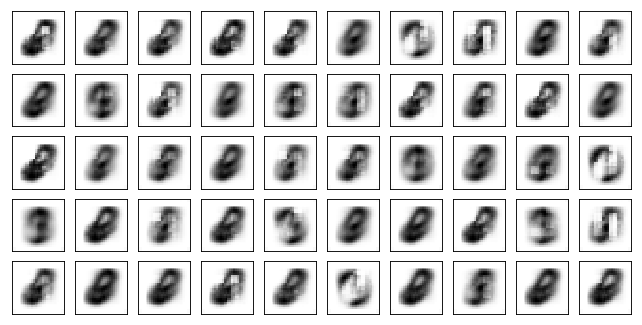

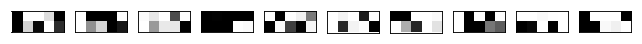

Model Adam Discr+bn+dp:


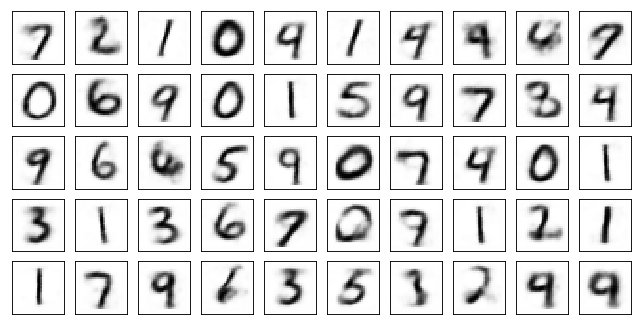

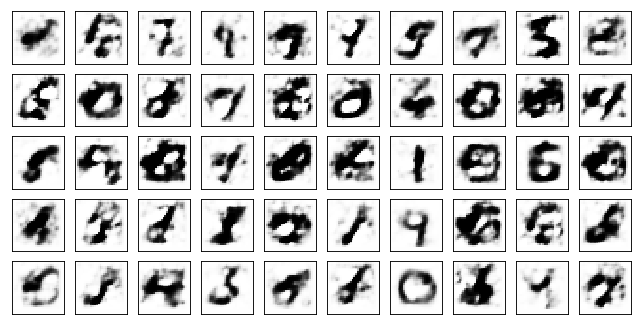

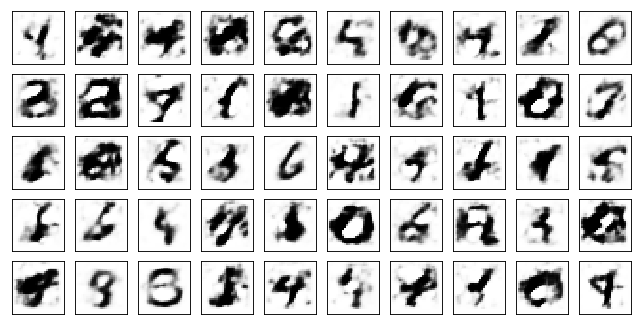

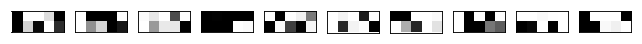

Test losses: 
Adam Discr+dp: 1.28218019 / 5.32804441 / 0.01167755 
Adam Discr+bn+dp: 0.66657352 / 4.47048950 / 0.01354088 

Train Epoch: 301 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1438 D:0.0072 Adam Discr+bn+dp: AE:0.9595 D:0.0008
Train Epoch: 301 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.2029 D:0.0003 Adam Discr+bn+dp: AE:0.9661 D:0.0589
Train Epoch: 301 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1164 D:0.0017 Adam Discr+bn+dp: AE:0.8932 D:0.0008
Test losses: 
Adam Discr+dp: 1.28454387 / 5.43982220 / 0.01067725 
Adam Discr+bn+dp: 0.66683853 / 4.30771637 / 0.00899349 

Train Epoch: 302 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1085 D:0.0008 Adam Discr+bn+dp: AE:0.9012 D:0.0034
Train Epoch: 302 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1212 D:0.0020 Adam Discr+bn+dp: AE:1.0033 D:0.0004
Train Epoch: 302 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1046 D:0.0004 Adam Discr+bn+dp: AE:0.9479 D:0.0710
Test losses: 
Adam Discr+dp: 1.28359246 / 5.48232460 / 0.01253432 
Ada

Train Epoch: 318 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1608 D:0.0010 Adam Discr+bn+dp: AE:0.9171 D:0.0016
Test losses: 
Adam Discr+dp: 1.28549433 / 5.69089222 / 0.01079633 
Adam Discr+bn+dp: 0.66523689 / 4.17000151 / 0.01034105 

Train Epoch: 319 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1670 D:0.0002 Adam Discr+bn+dp: AE:0.9178 D:0.0006
Train Epoch: 319 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1221 D:0.0004 Adam Discr+bn+dp: AE:0.9272 D:0.0012
Train Epoch: 319 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.2051 D:0.0006 Adam Discr+bn+dp: AE:0.9188 D:0.0008
Test losses: 
Adam Discr+dp: 1.28441560 / 5.39253950 / 0.01052240 
Adam Discr+bn+dp: 0.66397023 / 4.39735270 / 0.01211897 

Train Epoch: 320 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1344 D:0.0003 Adam Discr+bn+dp: AE:0.8842 D:0.0004
Train Epoch: 320 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1575 D:0.0006 Adam Discr+bn+dp: AE:0.9837 D:0.0005
Train Epoch: 320 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1960 

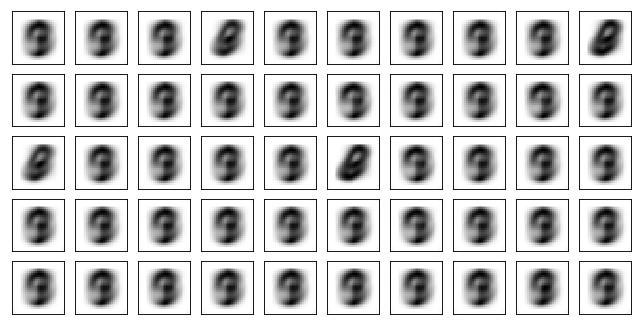

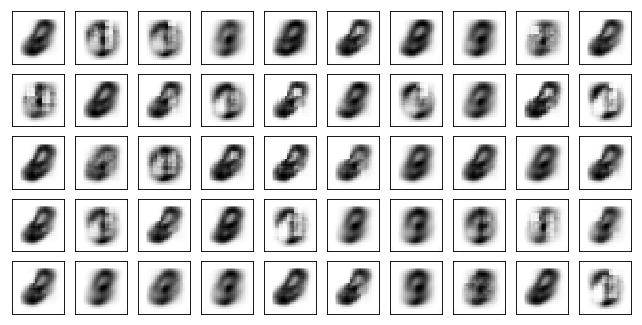

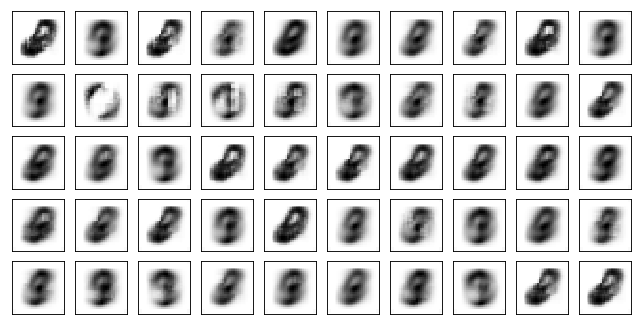

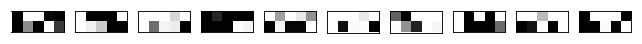

Model Adam Discr+bn+dp:


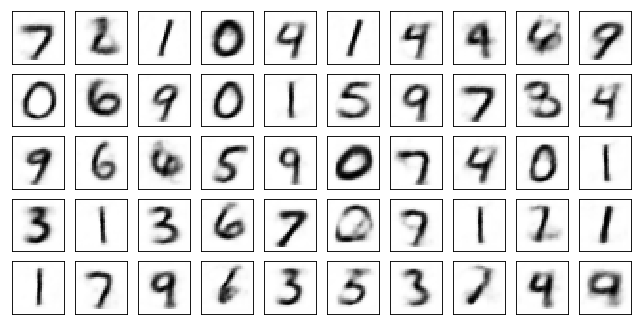

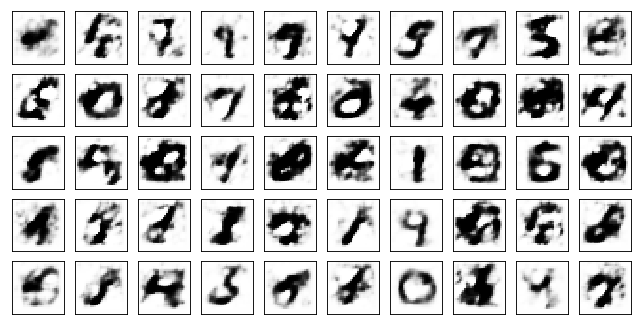

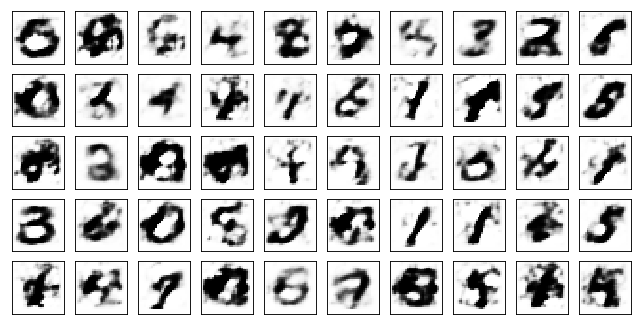

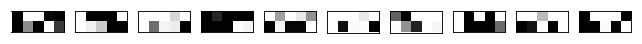

Test losses: 
Adam Discr+dp: 1.28522706 / 4.93427515 / 0.00925849 
Adam Discr+bn+dp: 0.66823441 / 4.65677500 / 0.01359609 

Train Epoch: 321 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.1638 D:0.0008 Adam Discr+bn+dp: AE:1.0238 D:0.0006
Train Epoch: 321 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1852 D:0.0002 Adam Discr+bn+dp: AE:0.9291 D:0.0004
Train Epoch: 321 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.2209 D:0.0004 Adam Discr+bn+dp: AE:0.9302 D:0.0018
Test losses: 
Adam Discr+dp: 1.28193879 / 5.38162899 / 0.00928005 
Adam Discr+bn+dp: 0.66341287 / 4.51499176 / 0.01286290 

Train Epoch: 322 [0/50000 (0%)]	Losses Adam Discr+dp: AE:1.2018 D:0.0087 Adam Discr+bn+dp: AE:0.9797 D:0.0007
Train Epoch: 322 [25000/50000 (50%)]	Losses Adam Discr+dp: AE:1.1396 D:0.0018 Adam Discr+bn+dp: AE:0.9298 D:0.0003
Train Epoch: 322 [50000/50000 (100%)]	Losses Adam Discr+dp: AE:1.1891 D:0.0004 Adam Discr+bn+dp: AE:0.9329 D:0.0005
Test losses: 
Adam Discr+dp: 1.29209244 / 5.74451828 / 0.01108193 
Ada

KeyboardInterrupt: 

In [16]:
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, 20, test_log)

In [20]:
test_reveal_period = 1
for model in models.values():
    model.eval()
test(models, valid_loader,1, test_log)

Test losses: 
Adam Discr+dp: 1.28771603 / 5.01686096 / 0.00877384 
Adam Discr+bn+dp: 0.65725505 / 4.58049202 / 0.00964170 



In [21]:
#torch.save(models['Adam Discr+bn'], './adam_ds_bn_l10_2')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l10_2')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l10_2')

/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Deconv

### Вывод результатов

In [22]:
model = torch.load('./adam_ds_bndp_l10_2')

In [26]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).cpu().data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(-1, 1).cpu().data.numpy()
    print ('enc=', encoded.shape)


enc= torch.Size([50, 10])


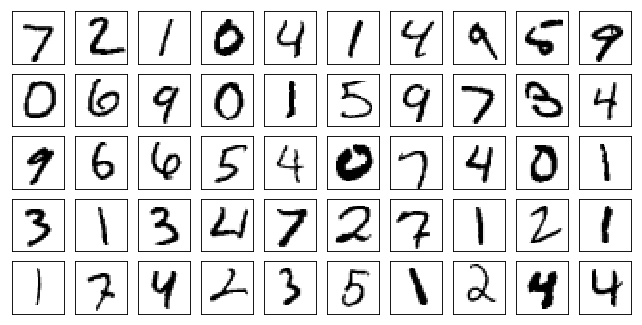

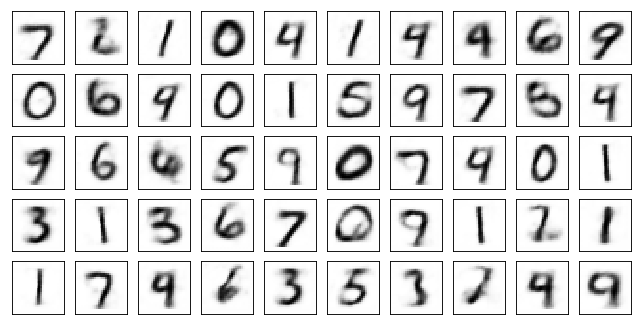

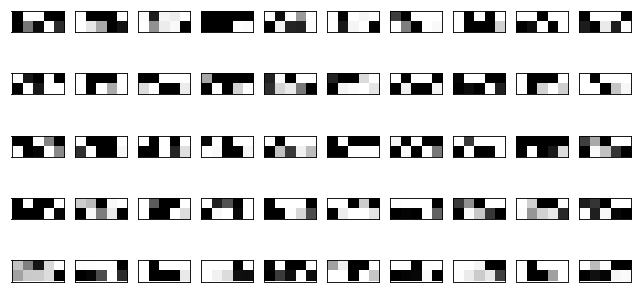

In [28]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [35]:
def show_generated_samples():
    pred_z = torch.randn((50, 10)).to(device)
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).cpu().data.numpy()  
    plot_mnist(generated, (5, 10))

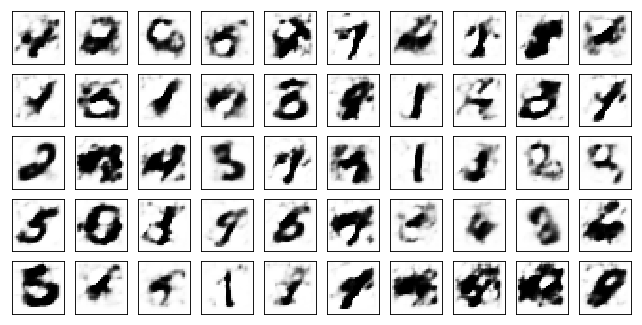

In [36]:
show_generated_samples()